# Attention

решать задачу классификации математических задач по темам (многоклассовая классификация) с помощью Transformer.

В качестве датасета возьмем датасет математических задач по разным темам. Нам необходим следующий файл:

[Файл с классами](https://docs.google.com/spreadsheets/d/1IMRxByfg7gjoZ5i7rxvuNDvSrbdOJOc-/edit?usp=drive_link&ouid=104379615679964018037&rtpof=true&sd=true)

In [ ]:
from typing import Union
import pandas as pd
from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from transformers import AutoTokenizer, AutoModel


sns.set(palette='summer')

**Requirments**

**Datasets**: is a powerful tool that provides a unified and easy-to-use interface to access and work with a wide range of datasets commonly used in NLP research and applications.

**Transformers**: library for working with pre-trained models in natural language processing, it provides an extensive collection of state-of-the-art models for tasks such as text generation, translation, sentiment analysis, and more.
**Evaluate**: a library for easily evaluating machine learning models and datasets.

**Sentencepiece**: is an unsupervised text tokenizer and detokenizer mainly used for Neural Network-based text generation systems where the vocabulary size is predetermined prior to the neural model training

**Accelerate**: a library providing a high-level interface for distributed training, making it easier for researchers and practitioners to scale their deep learning workflows across multiple GPUs or machines.

In [ ]:
!pip install -U accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.4/297.4 kB 6.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.2 MB/s eta 0:00:00


In [ ]:
!pip install transformers

In [ ]:
!pip install evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.4 MB/s eta 0:00:00


In [ ]:
import transformers
from datasets import load_dataset
import evaluate

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

I use data_problems.cvs and data_problems_en.cvs in this notebook.

data_problems.cvs is a dataset in russian and was converted from data_problems.xlsx provided for this task

data_problems_en is a russian to english translation + filtering of data_problems file and it was so kindly provided  by @Telrielnor.

The reason I use the translation with MathBERT model is that MathBERT is a transformers model pretrained on a large corpus of English math corpus data in a self-supervised fashion.

In [ ]:
math_problems_dataset = load_dataset("csv", data_files="data_problems.csv")

In [ ]:
math_problems_en_dataset = load_dataset("csv", data_files="data_problems_en.csv")

In [ ]:
math_problems_dataset

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'Задача', 'Тема'],
        num_rows: 5273
    })
})

In [ ]:
math_problems_en_dataset

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'Text', 'Topic', 'Text Length', 'Unnamed: 4'],
        num_rows: 3849
    })
})

In [ ]:
math_problems_dataset = math_problems_dataset['train']
math_problems_dataset = math_problems_dataset.remove_columns('Unnamed: 0')
math_problems_dataset = math_problems_dataset.rename_column('Задача', 'text')
math_problems_dataset = math_problems_dataset.rename_column('Тема', 'label')
math_problems_dataset

Dataset({
    features: ['text', 'label'],
    num_rows: 5273
})

In [ ]:
math_problems_en_dataset = math_problems_en_dataset['train']
math_problems_en_dataset = math_problems_en_dataset.remove_columns('Unnamed: 0')
math_problems_en_dataset = math_problems_en_dataset.rename_column('Text', 'text')
math_problems_en_dataset = math_problems_en_dataset.rename_column('Topic', 'label')
math_problems_en_dataset = math_problems_en_dataset.remove_columns('Text Length')
math_problems_en_dataset = math_problems_en_dataset.remove_columns('Unnamed: 4')
math_problems_en_dataset

Dataset({
    features: ['text', 'label'],
    num_rows: 3849
})

**Data Investigation**

In [ ]:
math_problems_dataset[100]

{'text': 'В квадрате отметили 20 точек и соединили их непересекающимися отрезками друг с другом и с вершинами квадрата так, что квадрат разбился на треугольники. Сколько получилось треугольников? ',
 'label': 'Графы'}

In [ ]:
math_problems_en_dataset

Dataset({
    features: ['text', 'label'],
    num_rows: 3849
})

In [ ]:
math_problems_en_dataset[10]

{'text': 'Several secret objects are connected by an underground railway in such a way that each object is directly connected to no more than three others and from each object can be reached underground to any other, making no more than one transplant.What is the maximum number of top secret objects?',
 'label': 1}

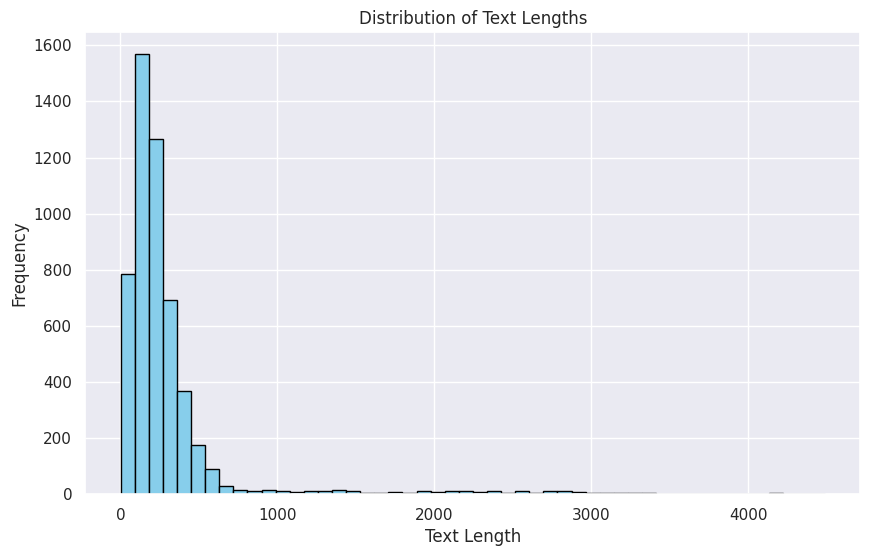

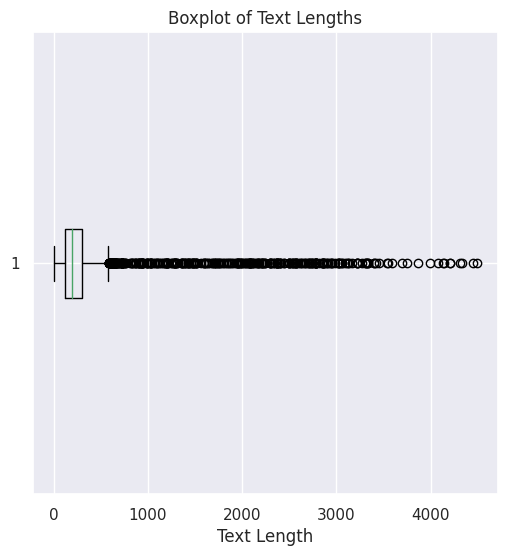

In [ ]:
import matplotlib.pyplot as plt

# Assuming math_problems_dataset is a pandas DataFrame or datasets.Dataset object
# Extract text lengths
text_lengths = [len(example['text']) for example in math_problems_dataset]

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(text_lengths, bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Plot boxplot
plt.figure(figsize=(6, 6))
plt.boxplot(text_lengths, vert=False)
plt.title('Boxplot of Text Lengths')
plt.xlabel('Text Length')
plt.grid(True)
plt.show()

In [ ]:
MAX_TEXT_LENGTH = 512

In [ ]:
from collections import defaultdict
import random

texts = math_problems_dataset['text']
labels = math_problems_dataset['label']

text_labels = defaultdict(list)
for text, label in zip(texts, labels):
    text_labels[text].append(label)

duplicates = {text: (labels, len(labels)) for text, labels in text_labels.items() if len(labels) > 1}
print(f"Duplicates are {len(duplicates)} out of {len(texts)} raw texts")

num_duplicates_to_print = 5
random_duplicates = random.sample(duplicates.items(), num_duplicates_to_print)
for text, (labels, _) in random_duplicates:
    print("Text:", text)
    print("Labels:", labels)
    print()


Duplicates are 762 out of 5273 raw texts
Text: Миша написал на доске в некотором порядке 2004 плюса и 2005 минусов. Время от времени Юра подходит к доске, стирает любые два знака и пишет вместо них один, причём если он стёр одинаковые знаки, то вместо них он пишет плюс, а если разные, то минус. После нескольких таких действий на доске остался только один знак. Какой? 
Labels: ['Теория чисел', 'Инвариант']

Text: а) Есть 128 монет двух различных весов, монет каждого веса поровну. Как на чашечных весах без гирь гарантированно найти две монеты разного веса не более чем за семь взвешиваний? 
б) Есть восемь монет двух различных весов, монет каждого веса поровну. Как на чашечных весах без гирь гарантированно найти две монеты разного веса за два взвешивания? 
Labels: ['Теория чисел', 'Инвариант']

Text:    а) Пусть q – натуральное число и функция  
f(x) = cqx + anxn + ... + a1x + a0  принимает целые значения при  x = 0, 1, 2, ..., n + 1. 
Докажите, что при любом натуральном x число  f(x) такж

<ipython-input-19-2f8559b12e0c>:15: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  random_duplicates = random.sample(duplicates.items(), num_duplicates_to_print)


In [ ]:
unique_topics = set(math_problems_dataset['label'])
unique_topics

{'Геометрия',
 'Графы',
 'Дирихле',
 'Инвариант',
 'Комбинаторика',
 'Многочлен',
 'Теория чисел'}

In [ ]:
num_topics = len(unique_topics)
num_topics

7

In [ ]:
from collections import Counter

# Count the occurrences of each label
labels = math_problems_dataset['label']
label_counts = Counter(labels)

# Calculate the total number of instances
total_instances = sum(label_counts.values())

# Calculate the percentage of each label
label_percentages = {label: count / total_instances * 100 for label, count in label_counts.items()}

# Print the results
print("Label counts:")
for label, count in label_counts.items():
    print(f"{label}: {count}")

print("\nLabel percentages:")
for label, percentage in label_percentages.items():
    print(f"{label}: {percentage:.2f}%")

Label counts:
Графы: 384
Геометрия: 371
Многочлен: 426
Комбинаторика: 1020
Теория чисел: 2396
Инвариант: 235
Дирихле: 441

Label percentages:
Графы: 7.28%
Геометрия: 7.04%
Многочлен: 8.08%
Комбинаторика: 19.34%
Теория чисел: 45.44%
Инвариант: 4.46%
Дирихле: 8.36%


**Conclusions:**
1. The raw data consists of texts with multiple labels, even though the task is designed for multi-class classification.
2. The dataset exhibits significant class imbalance, with approximately 45% of the samples labeled as "Теория чисел".
3.The dataset contains instances of junk text, which include solutions, website context, and other irrelevant content. This presence of irrelevant text poses a challenge and needs to be addressed.

**Preprocessing**

1.   Remove junk text
2.   Remove duplicate of texts with diferent labels.


In [ ]:
def is_junk_text(text):
  return len(text) > MAX_TEXT_LENGTH

In [ ]:
from datasets import Dataset
unique_texts = set()
filtered_examples = []

# Iterate through examples and add to filtered_dataset only if text is not a duplicate
for example in math_problems_dataset:
    text = example['text']
    if  not is_junk_text(text) and text not in unique_texts:
        unique_texts.add(text)
        filtered_examples.append(example)


filtered_dataset = Dataset.from_list(filtered_examples)
filtered_dataset

Dataset({
    features: ['text', 'label'],
    num_rows: 3939
})

In [ ]:
math_problems_dataset = filtered_dataset
math_problems_dataset

Dataset({
    features: ['text', 'label'],
    num_rows: 3939
})

In [ ]:
math_problems_en_dataset

Dataset({
    features: ['text', 'label'],
    num_rows: 3849
})

TBD: Consider dealing with unbalanced dataset: Add sampler with normal distribution per label

In [ ]:
math_problems_dataset = math_problems_dataset.train_test_split(test_size=0.1)
math_problems_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 3545
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 394
    })
})

In [ ]:
math_problems_en_dataset = math_problems_en_dataset.train_test_split(test_size=0.1)
math_problems_en_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 3464
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 385
    })
})

In [ ]:
for i in range(3):
  print("problem:", i)
  print(math_problems_dataset['train'][i])
  print()

problem: 0
{'text': 'На доске размером 15×15 клеток расставили 15 ладей, не бьющих друг друга.\r\nЗатем каждую ладью передвинули ходом коня. \r\nДокажите, что теперь какие-то две ладьи будут бить друг друга. ', 'label': 'Теория чисел'}

problem: 1
{'text': 'Существует ли такой набор из 10 натуральных чисел, что каждое не делится ни\r\nна одно из остальных, а квадрат каждого делится на каждое из остальных? ', 'label': 'Теория чисел'}

problem: 2
{'text': 'Через центр O описанной окружности остроугольного треугольника ABC, проведена прямая, перпендикулярная BO и пересекающая отрезок AB в точке P и продолжение отрезка BC за точку C в точке Q. Найдите BP, если известно, что \xa0AB = c,\xa0 BC = a\xa0 и \xa0BQ = p. ', 'label': 'Геометрия'}



In [ ]:
for i in range(3):
  print("problem:", i)
  print(math_problems_en_dataset['train'][i])
  print()

problem: 0
{'text': 'There are many C, consisting of n elements.How many ways can be selected in C two subset A and B so that\r\n\r\na) the set A and B did not intersect;\r\nb) a lot of A would be contained in many B?', 'label': 4}

problem: 1
{'text': 'The chip stands on one of the fields of an endless plate of paper in both directions.It can shift to m fields to the right or to n fields to the left.At what M and N can she move to a cell neighboring right?', 'label': 6}

problem: 2
{'text': 'In the vertices of the cube, numbers 1, 2, ..., 8. Prove that there is a rib, the numbers at the ends of which differ by at least 3.', 'label': 2}



In [ ]:
math_problem_en = math_problems_en_dataset['train'][0]['text']
math_problem_en

'There are many C, consisting of n elements.How many ways can be selected in C two subset A and B so that\r\n\r\na) the set A and B did not intersect;\r\nb) a lot of A would be contained in many B?'

SciRus-tiny is a model to obtain embeddings of scientific texts in russian and english. Model was trained on eLibrary data with contrastive technics described in habr post. High metrics values were achieved on the ruSciBench benchmark.
[Link](
https://huggingface.co/mlsa-iai-msu-lab/sci-rus-tiny)

RuBERT (Russian, cased, 12‑layer, 768‑hidden, 12‑heads, 180M parameters) was trained on the Russian part of Wikipedia and news data. We used this training data to build a vocabulary of Russian subtokens and took a multilingual version of BERT‑base as an initialization for RuBERT[1].
[Link](
https://huggingface.co/DeepPavlov/rubert-base-cased)

In [ ]:
checkpoint = "mlsa-iai-msu-lab/sci-rus-tiny" # - did not work well
checkpoint = "DeepPavlov/rubert-base-cased" # - works well


In [ ]:
checkpoint = 'cointegrated/rubert-tiny2'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
# tokenizer = AutoTokenizer.from_pretrained(checkpoint, padding=True, truncation=True, max_length=512)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/401 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.74M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
math_problem = math_problems_dataset['train'][0]['text']
inputs = tokenizer(math_problem)
inputs

{'input_ids': [2, 1041, 52437, 36872, 629, 17000, 12044, 33956, 49633, 4307, 629, 70935, 1668, 16, 769, 56884, 10284, 8230, 8222, 18, 11258, 33517, 70935, 8506, 47149, 32538, 41682, 49808, 18, 3130, 872, 31206, 16, 1046, 16623, 29860, 17, 1619, 3389, 70935, 14771, 16312, 45343, 8230, 8222, 18, 3], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [ ]:
math_problem

'На доске размером 15×15 клеток расставили 15 ладей, не бьющих друг друга.\r\nЗатем каждую ладью передвинули ходом коня. \r\nДокажите, что теперь какие-то две ладьи будут бить друг друга. '

In [ ]:
len(math_problem)

183

In [ ]:
tokenizer.convert_ids_to_tokens(inputs["input_ids"])

['[CLS]',
 'На',
 'доске',
 'размером',
 '15',
 '##×',
 '##15',
 'клеток',
 'расстав',
 '##или',
 '15',
 'лад',
 '##ей',
 ',',
 'не',
 'бью',
 '##щих',
 'друг',
 'друга',
 '.',
 'Затем',
 'каждую',
 'лад',
 '##ью',
 'передви',
 '##нули',
 'ходом',
 'коня',
 '.',
 'До',
 '##ка',
 '##жите',
 ',',
 'что',
 'теперь',
 'какие',
 '-',
 'то',
 'две',
 'лад',
 '##ьи',
 'будут',
 'бить',
 'друг',
 'друга',
 '.',
 '[SEP]']

In [ ]:
classes = list(set([label for label in math_problems_dataset['train']['label'] if label]))
class2id = {label: idx for idx, label in enumerate(classes)}
id2class = {idx: label for label, idx in class2id.items()}

In [ ]:
class2id

{'Геометрия': 0,
 'Теория чисел': 1,
 'Дирихле': 2,
 'Графы': 3,
 'Многочлен': 4,
 'Инвариант': 5,
 'Комбинаторика': 6}

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

In [ ]:
def preprocess_function(examples):
    model_inputs = tokenizer(examples["text"],padding='max_length', truncation=True, max_length=512, return_tensors='pt')

    # labels = [class2id[label] for label in examples["label"]]
    # model_inputs["labels"] = torch.tensor(labels)
    encoded_labels = label_encoder.fit_transform(examples["label"])
    model_inputs["labels"] = torch.tensor(encoded_labels)

    return model_inputs

In [ ]:
tokenized_math_problems_dataset = math_problems_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/3545 [00:00<?, ? examples/s]

Map:   0%|          | 0/394 [00:00<?, ? examples/s]

In [ ]:
tokenized_math_problems_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 3545
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 394
    })
})

In [ ]:
print("topic(label):", tokenized_math_problems_dataset['train']['label'][1])
print("label:", tokenized_math_problems_dataset['train']['labels'][1])

topic(label): Теория чисел
label: 6


In [ ]:
MathBERT_checkpoint = 'tbs17/MathBERT'
MathBERT_tokenizer = AutoTokenizer.from_pretrained(MathBERT_checkpoint, padding=True, truncation=True, max_length=512)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/569 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
def MathBERT_preprocess_function(examples):
    model_inputs = MathBERT_tokenizer(examples["text"],padding='max_length', truncation=True, max_length=512, return_tensors='pt')
    model_inputs["labels"] = torch.tensor(examples["label"])
    # encoded_labels = label_encoder.fit_transform(examples["label"])
    # model_inputs["labels"] = torch.tensor(encoded_labels)

    return model_inputs

In [ ]:
tokenized_math_problems_en_dataset = math_problems_en_dataset.map(MathBERT_preprocess_function, batched=True)
tokenized_math_problems_en_dataset

Map:   0%|          | 0/3464 [00:00<?, ? examples/s]

Map:   0%|          | 0/385 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 3464
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 385
    })
})

In [ ]:
print("topic(label):", tokenized_math_problems_en_dataset['train']['label'][1])
print("label:", tokenized_math_problems_en_dataset['train']['labels'][1])

topic(label): 6
label: 6


In [ ]:
from torch.utils.data import TensorDataset, DataLoader

def get_data_loaders(tokenized_dataset, batch_size=16):

    train_tokenized_dataset = tokenized_dataset['train']
    test_tokenized_dataset = tokenized_dataset['test']


    train_dataset = TensorDataset(torch.tensor(train_tokenized_dataset['input_ids']),
                                  torch.tensor(train_tokenized_dataset['token_type_ids']),
                                  torch.tensor(train_tokenized_dataset['attention_mask']),
                                  torch.tensor(train_tokenized_dataset['labels']))
    test_dataset = TensorDataset(torch.tensor(test_tokenized_dataset['input_ids']),
                                 torch.tensor(test_tokenized_dataset['token_type_ids']),
                                 torch.tensor(test_tokenized_dataset['attention_mask']),
                                 torch.tensor(test_tokenized_dataset['labels']))


    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader


In [ ]:
train_loader, test_loader =  get_data_loaders(tokenized_math_problems_dataset)


In [ ]:
MathBERT_train_loader, MathBERT_test_loader =  get_data_loaders(tokenized_math_problems_en_dataset)

In [ ]:
for batch in train_loader:
    input_ids, token_type_ids, attention_mask, labels = batch

    print("Input IDs:", input_ids)
    print("Input IDs.shape:", input_ids.shape)
    print("Token type IDs:", token_type_ids)
    print("Token type IDs.shape:", token_type_ids.shape)
    print("Attention Mask:", attention_mask)
    print("Attention Mask.shape:", attention_mask.shape)
    print("Labels:", labels)
    print("Labels.shape:", labels.shape)
    print("\n")
    break

Input IDs: tensor([[    2, 41905, 11106,  ...,     0,     0,     0],
        [    2,  3130,   872,  ...,     0,     0,     0],
        [    2,   282, 32070,  ...,     0,     0,     0],
        ...,
        [    2,  1041, 53639,  ...,     0,     0,     0],
        [    2,  1041, 18806,  ...,     0,     0,     0],
        [    2, 13584, 33374,  ...,     0,     0,     0]])
Input IDs.shape: torch.Size([16, 512])
Token type IDs: tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])
Token type IDs.shape: torch.Size([16, 512])
Attention Mask: tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])
Attention Mask.shape: torch.Size([16, 512])
Labels: tensor([5, 6, 0, 6, 4, 6

In [ ]:
for batch in MathBERT_train_loader:
    input_ids, token_type_ids, attention_mask, labels = batch
    print("Input IDs:", input_ids)
    print("Input IDs.shape:", input_ids.shape)
    print("Token type IDs:", token_type_ids)
    print("Token type IDs.shape:", token_type_ids.shape)
    print("Attention Mask:", attention_mask)
    print("Attention Mask.shape:", attention_mask.shape)
    print("Labels:", labels)
    print("Labels.shape:", labels.shape)
    print("\n")
    break


Input IDs: tensor([[  101,  1996,  5537,  ...,     0,     0,     0],
        [  101,  2424,  1037,  ...,     0,     0,     0],
        [  101,  1039,  1007,  ...,     0,     0,     0],
        ...,
        [  101,  1999,  1996,  ...,     0,     0,     0],
        [  101,  2006,  1996,  ...,     0,     0,     0],
        [  101, 17505,  1052,  ...,     0,     0,     0]])
Input IDs.shape: torch.Size([16, 512])
Token type IDs: tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])
Token type IDs.shape: torch.Size([16, 512])
Attention Mask: tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])
Attention Mask.shape: torch.Size([16, 512])
Labels: tensor([6, 6, 6, 6, 4, 2

### Задание 1 (2 балла)

Напишите кастомный класс для модели трансформера для задачи классификации, использующей в качествке backbone какую-то из моделей huggingface.

Т.е. конструктор класса должен принимать на вход название модели и подгружать её из huggingface, а затем использовать в качестве backbone (достаточно возможности использовать в качестве backbone те модели, которые упомянуты в последующих пунктах)

In [ ]:
class TransformerClassificationModel(nn.Module):
  def __init__(self, base_transformer_model: Union[str, nn.Module], num_classes = num_topics):
        super(TransformerClassificationModel, self).__init__()

        if isinstance(base_transformer_model, str):
            # Load pre-trained model from Hugging Face
            self.backbone = AutoModel.from_pretrained(base_transformer_model)
        elif isinstance(base_transformer_model, nn.Module):
            self.backbone = base_transformer_model
        else:
            raise ValueError("base_transformer_model must be a string or nn.Module")

        # Additional layers for classification
        self.classifier = nn.Linear(self.backbone.config.hidden_size, num_classes)


  def forward(self, input_ids, attention_mask=None, token_type_ids=None):
    outputs = self.backbone(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
    pooled_output = outputs.pooler_output
    logits = self.classifier(pooled_output)
    return {"logits": logits}

In [ ]:
def eval_n_print_batch(model, data_loader):
  model.eval()
  with torch.no_grad():
      for input_ids, token_type_ids, attention_mask, labels in data_loader:
          input_ids = input_ids.to(device)
          token_type_ids = token_type_ids.to(device)
          attention_mask = attention_mask.to(device)


          outputs = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
          predictions = torch.argmax(outputs['logits'], dim=1)
          predicted = label_encoder.inverse_transform(predictions.cpu().numpy())
          labels = label_encoder.inverse_transform(labels.numpy())

          print("Predictions:", predicted)
          print("Labels:", labels)
          break



### Задание 2 (1 балл)

Напишите функцию заморозки backbone у модели (если необходимо, возвращайте из функции модель)

In [ ]:
def freeze_backbone_function(model: TransformerClassificationModel):
    for param in model.backbone.parameters():
        param.requires_grad = False

    return model

### Задание 3 (2 балла)

Напишите функцию, которая будет использована для тренировки (дообучения) трансформера (TransformerClassificationModel). Функция должна поддерживать обучение с замороженным и размороженным backbone.

In [ ]:
import os

# Create the output directory if it doesn't exist
output_dir = "./results"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Create the logging directory if it doesn't exist
logging_dir = "./logs"
if not os.path.exists(logging_dir):
    os.makedirs(logging_dir)

In [ ]:
from transformers import TrainingArguments, Trainer, DataCollatorWithPadding

def train_transformer(checkpoint, dataset, freeze_backbone=True):
    transformer_model = TransformerClassificationModel(checkpoint)

    # Freeze or unfreeze backbone layers based on the provided flag
    if freeze_backbone:
        transformer_model = freeze_backbone_function(transformer_model)

    tokenizer = AutoTokenizer.from_pretrained(checkpoint, padding=True, truncation=True, max_length=512)
    data_collator = transformers.DataCollatorWithPadding(tokenizer=tokenizer)


    # Define training arguments
    training_args = TrainingArguments(
        output_dir="./results",
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        num_train_epochs=3,
        evaluation_strategy="epoch",
        logging_dir="./logs",
        remove_unused_columns=True

    )

    # Initialize the Trainer instance
    trainer = transformers.Trainer(
        model=transformer_model,                # The model to be trained
        args=training_args,                     # Training arguments
        train_dataset=dataset['train'],         # Training dataset
        eval_dataset=dataset['test'],           # Evaluation dataset
        tokenizer=tokenizer,                    # Tokenizer for processing inputs
        data_collator=data_collator,            # Data collator for batch processing
        # device=device
    )

    # Train the model
    train_results = trainer.train()

    # Get the training history
    train_loss_history = train_results.metrics["train_loss"]
    train_accuracy_history = train_results.metrics["train_accuracy"]

    # Get the evaluation history
    eval_loss_history = train_results.metrics["eval_loss"]
    eval_accuracy_history = train_results.metrics["eval_accuracy"]

    # Combine into dictionaries for easier plotting
    loss_history = {'train': train_loss_history, 'val': eval_loss_history}
    accuracy_history = {'train': train_accuracy_history, 'val': eval_accuracy_history}

    return transformer_model, loss_history, accuracy_history

In [ ]:
def train_epoch(model, train_loader, criterion, optimizer, device, epoch):
    model.train()
    running_loss = 0.0
    total_samples = len(train_loader.dataset)

    with tqdm(total=total_samples, desc=f'Train epoch {epoch}', unit=' samples', position=0, leave=True) as pbar:

      for input_ids, token_type_ids, attention_mask, labels in train_loader:
          input_ids, token_type_ids, attention_mask, labels = input_ids.to(device), token_type_ids.to(device), attention_mask.to(device), labels.to(device)
          optimizer.zero_grad()

          outputs = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
          logits = outputs['logits']

          loss = criterion(logits, labels)
          loss.backward()
          optimizer.step()

          running_loss += loss.item()
          pbar.update(labels.size(0))

      return running_loss / len(train_loader)

In [ ]:
def evaluate_epoch(model, data_loader, criterion, device, epoch):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0
    total_samples = len(data_loader.dataset)

    with torch.no_grad(), tqdm(total=total_samples, desc=f'Eval Epoch {epoch}', unit=' samples', leave=False) as pbar:
        for input_ids, token_type_ids, attention_mask, labels in train_loader:
          input_ids, token_type_ids, attention_mask, labels = input_ids.to(device), token_type_ids.to(device), attention_mask.to(device), labels.to(device)
          outputs = model(input_ids=input_ids, attention_mask=attention_mask,token_type_ids=token_type_ids)
          logits = outputs['logits']
          _, predicted = torch.max(logits, 1)

          total += labels.size(0)
          correct += (predicted == labels).sum().item()

          loss = criterion(logits, labels)
          running_loss += loss.item()

          pbar.update(labels.size(0))

    accuracy = (correct / total) * 100
    avg_loss = running_loss / len(data_loader)
    return accuracy, avg_loss

In [ ]:
def train_transformer(checkpoint, train_loader=train_loader, test_loader=test_loader, freeze_backbone=True,  num_epochs = 5):
    transformer_model = TransformerClassificationModel(checkpoint).to(device)

    # Freeze or unfreeze backbone layers based on the provided flag
    if freeze_backbone:
        transformer_model = freeze_backbone_function(transformer_model)

    criterion = nn.CrossEntropyLoss()

    lr=5e-5
    optimizer = torch.optim.Adam(transformer_model.parameters(), lr=lr)

    loss_history, accuracy_history = {'train':[], 'val':[]}, {'train':[], 'val':[]}
    best_val_loss = np.inf
    best_model = None

    with tqdm(total=num_epochs, desc=f'Transformer {checkpoint} fine tuning', unit='epoch', leave=True) as epoch_pbar:
      for epoch in range(num_epochs):
            train_loss = train_epoch(transformer_model, train_loader, criterion, optimizer, device, epoch+1)
            train_accuracy, _ = evaluate_epoch(transformer_model, train_loader, criterion, device, epoch+1)
            val_accuracy, val_loss = evaluate_epoch(transformer_model, test_loader, criterion, device, epoch+1)

            print(f"Epoch {epoch}/{num_epochs}:")
            print(f"\tTrain Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%")
            print(f"\tValidation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.2f}%")

            loss_history['train'].append(train_loss)
            loss_history['val'].append(val_loss)
            accuracy_history['train'].append(train_accuracy)
            accuracy_history['val'].append(val_accuracy)

            epoch_pbar.update(1)
            if val_loss < best_val_loss:
                  best_val_loss = val_loss
                  best_model = transformer_model.state_dict()

    if best_model is not None:
          torch.save(best_model, 'best_model_weights.pth')

    return transformer_model, loss_history, accuracy_history

In [ ]:
def plot_loss_accuracy(loss_history, accuracy_history, model_name):
    sns.set_style("darkgrid")

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    axes[0].plot(range(1, len(loss_history['train']) + 1), loss_history['train'], color='blue')
    axes[0].plot(range(1, len(loss_history['val']) + 1), loss_history['val'], color='green')
    axes[0].set_title(model_name +' Loss History')
    axes[0].legend(['Train', 'Validation'])

    axes[1].plot(range(1, len(accuracy_history['train']) + 1), accuracy_history['train'], color='gold')
    axes[1].plot(range(1, len(accuracy_history['val']) + 1), accuracy_history['val'], color='red')
    axes[1].set_title(model_name + ' Accuracy History')
    axes[1].legend(['Train', 'Validation'])

    fig.suptitle(model_name)
    plt.show()

### Задание 4 (1 балл)

Проверьте вашу функцию из предыдущего пункта, дообучив двумя способами
*cointegrated/rubert-tiny2* из huggingface.

In [ ]:
# Using huggingface API
# will back to work on it later
# checkpoint = 'cointegrated/rubert-tiny2'
# rubert_tiny_finetuned_with_freezed_backbone, rubert_tiny_l_history_with_freezed_backbone, rubert_tiny_a_history_with_freezed_backbone = train_transformer(checkpoint, tokenized_math_problems_dataset, freeze_backbone=True)
# rubert_tiny_full_finetuned, rubert_tiny_l_history_full_finetuned, rubert_tiny_a_history_full_finetuned = train_transformer(checkpoint, tokenized_math_problems_dataset, freeze_backbone=False)



In [ ]:
rubert_tiny_checkpoint = 'cointegrated/rubert-tiny2'

rubert_tiny_finetuned_with_freezed_backbone, rubert_tiny_l_history_with_freezed_backbone, rubert_tiny_a_history_with_freezed_backbone = train_transformer(rubert_tiny_checkpoint, freeze_backbone=True,  num_epochs = 5)
rubert_tiny_full_finetuned, rubert_tiny_l_history_full_finetuned, rubert_tiny_a_history_full_finetuned = train_transformer(rubert_tiny_checkpoint, freeze_backbone=False,  num_epochs = 3)


Transformer cointegrated/rubert-tiny2 fine tuning:   0%|          | 0/5 [00:00<?, ?epoch/s]

Train epoch 1:   0%|          | 0/3613 [00:00<?, ? samples/s]

Eval Epoch 1:   0%|          | 0/3613 [00:00<?, ? samples/s]

Eval Epoch 1:   0%|          | 0/402 [00:00<?, ? samples/s]

Epoch 0/5:
	Train Loss: 0.5998, Accuracy: 84.94%
	Validation Loss: 3.9446, Accuracy: 84.94%


Train epoch 2:   0%|          | 0/3613 [00:00<?, ? samples/s]

Eval Epoch 2:   0%|          | 0/3613 [00:00<?, ? samples/s]

Eval Epoch 2:   0%|          | 0/402 [00:00<?, ? samples/s]

Epoch 1/5:
	Train Loss: 0.5270, Accuracy: 87.68%
	Validation Loss: 3.4502, Accuracy: 87.68%


Train epoch 3:   0%|          | 0/3613 [00:00<?, ? samples/s]

Eval Epoch 3:   0%|          | 0/3613 [00:00<?, ? samples/s]

Eval Epoch 3:   0%|          | 0/402 [00:00<?, ? samples/s]

Epoch 2/5:
	Train Loss: 0.4304, Accuracy: 90.15%
	Validation Loss: 2.6767, Accuracy: 90.15%


Train epoch 4:   0%|          | 0/3613 [00:00<?, ? samples/s]

Eval Epoch 4:   0%|          | 0/3613 [00:00<?, ? samples/s]

Eval Epoch 4:   0%|          | 0/402 [00:00<?, ? samples/s]

Epoch 3/5:
	Train Loss: 0.3222, Accuracy: 94.99%
	Validation Loss: 1.4991, Accuracy: 94.99%


Train epoch 5:   0%|          | 0/3613 [00:00<?, ? samples/s]

Eval Epoch 5:   0%|          | 0/3613 [00:00<?, ? samples/s]

Eval Epoch 5:   0%|          | 0/402 [00:00<?, ? samples/s]

Epoch 4/5:
	Train Loss: 0.2516, Accuracy: 94.69%
	Validation Loss: 1.3569, Accuracy: 94.69%


Transformer cointegrated/rubert-tiny2 fine tuning:   0%|          | 0/3 [00:00<?, ?epoch/s]

Train epoch 1:   0%|          | 0/3613 [00:00<?, ? samples/s]

Eval Epoch 1:   0%|          | 0/3613 [00:00<?, ? samples/s]

Eval Epoch 1:   0%|          | 0/402 [00:00<?, ? samples/s]

Epoch 0/3:
	Train Loss: 0.2243, Accuracy: 97.07%
	Validation Loss: 1.0041, Accuracy: 97.07%


Train epoch 2:   0%|          | 0/3613 [00:00<?, ? samples/s]

Eval Epoch 2:   0%|          | 0/3613 [00:00<?, ? samples/s]

Eval Epoch 2:   0%|          | 0/402 [00:00<?, ? samples/s]

Epoch 1/3:
	Train Loss: 0.1830, Accuracy: 93.86%
	Validation Loss: 1.5471, Accuracy: 93.86%


Train epoch 3:   0%|          | 0/3613 [00:00<?, ? samples/s]

Eval Epoch 3:   0%|          | 0/3613 [00:00<?, ? samples/s]

Eval Epoch 3:   0%|          | 0/402 [00:00<?, ? samples/s]

Epoch 2/3:
	Train Loss: 0.1674, Accuracy: 97.81%
	Validation Loss: 0.6697, Accuracy: 97.81%


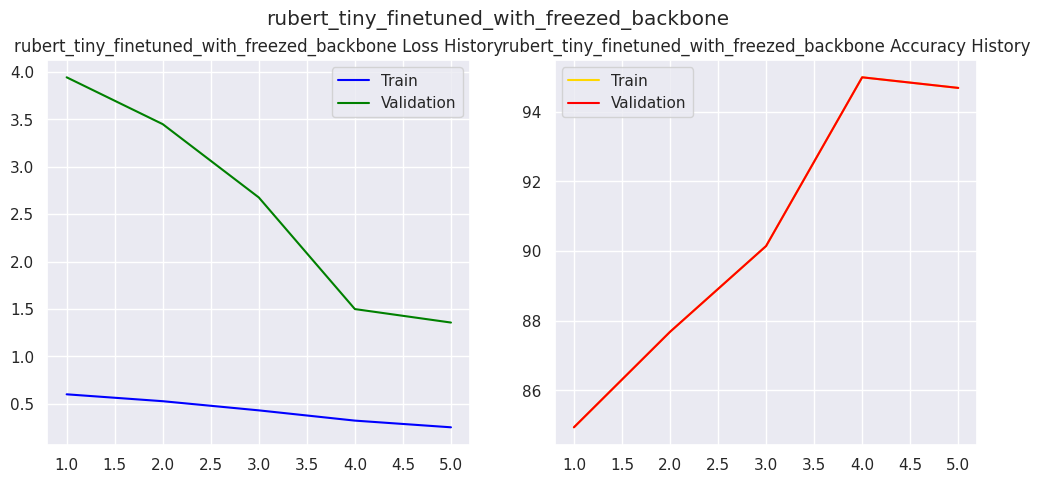

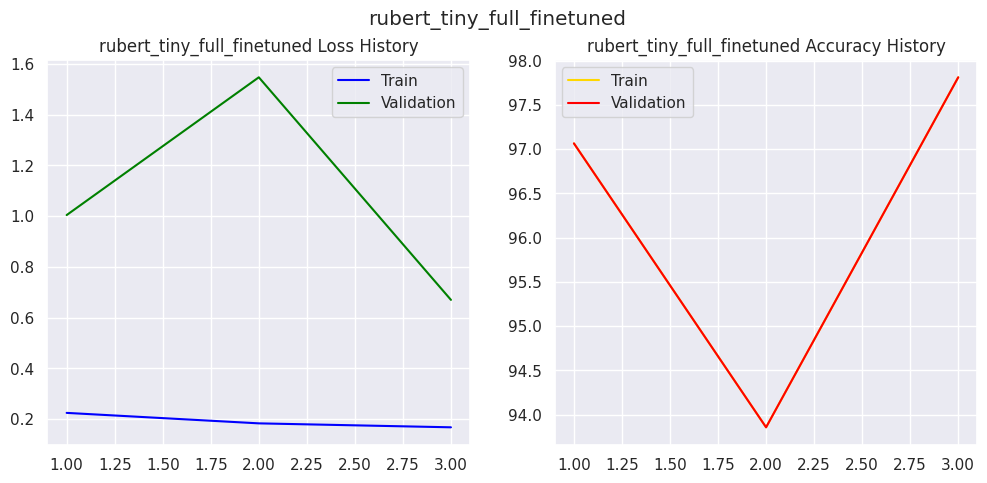

In [ ]:
# Plot loss and accuracy history
plot_loss_accuracy(rubert_tiny_l_history_with_freezed_backbone, rubert_tiny_a_history_with_freezed_backbone, "rubert_tiny_finetuned_with_freezed_backbone")
plot_loss_accuracy(rubert_tiny_l_history_full_finetuned, rubert_tiny_a_history_full_finetuned, "rubert_tiny_full_finetuned")

### Задание 5 (1 балл)

Обучите *tbs17/MathBert* (с замороженным backbone и без заморозки), проанализируйте результаты. Сравните скоры с первым заданием. Получилось лучше или нет? Почему?

MathBERT was trained on a 8-core cloud TPUs from Google Colab for 600k steps with a batch size of 128. The sequence length was limited to 512 for the entire time. The optimizer used is Adam with a learning rate of 5e-5, beta_{1} = 0.9 and beta_{2} =0.999, a weight decay of 0.01, learning rate warmup for 10,000 steps and linear decay of the learning rate after.

https://huggingface.co/tbs17/MathBERT

In [ ]:
mathBERT_checkpoint = 'tbs17/MathBERT'

mathBERT_finetuned_with_freezed_backbone, MathBERT_l_history_with_freezed_backbone, MathBERT_a_history_with_freezed_backbone = train_transformer(checkpoint, train_loader=MathBERT_train_loader, test_loader=MathBERT_test_loader, freeze_backbone=True,  num_epochs = 5)
mathBERT_full_finetuned, MathBERT_l_history_full_finetuned, MathBERT_a_history_full_finetuned = train_transformer(checkpoint, train_loader=MathBERT_train_loader, test_loader=MathBERT_test_loader, freeze_backbone=False,  num_epochs = 3)


config.json:   0%|          | 0.00/693 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/118M [00:00<?, ?B/s]

Transformer cointegrated/rubert-tiny2 fine tuning:   0%|          | 0/5 [00:00<?, ?epoch/s]

Train epoch 1:   0%|          | 0/3464 [00:00<?, ? samples/s]

Eval Epoch 1:   0%|          | 0/3464 [00:00<?, ? samples/s]

Eval Epoch 1:   0%|          | 0/385 [00:00<?, ? samples/s]

Epoch 0/5:
	Train Loss: 1.8242, Accuracy: 15.97%
	Validation Loss: 17.1477, Accuracy: 15.97%


Train epoch 2:   0%|          | 0/3464 [00:00<?, ? samples/s]

Eval Epoch 2:   0%|          | 0/3464 [00:00<?, ? samples/s]

Eval Epoch 2:   0%|          | 0/385 [00:00<?, ? samples/s]

Epoch 1/5:
	Train Loss: 1.6303, Accuracy: 27.11%
	Validation Loss: 16.8621, Accuracy: 27.11%


Train epoch 3:   0%|          | 0/3464 [00:00<?, ? samples/s]

Eval Epoch 3:   0%|          | 0/3464 [00:00<?, ? samples/s]

Eval Epoch 3:   0%|          | 0/385 [00:00<?, ? samples/s]

Epoch 2/5:
	Train Loss: 1.5433, Accuracy: 31.28%
	Validation Loss: 16.6722, Accuracy: 31.28%


Train epoch 4:   0%|          | 0/3464 [00:00<?, ? samples/s]

Eval Epoch 4:   0%|          | 0/3464 [00:00<?, ? samples/s]

Eval Epoch 4:   0%|          | 0/385 [00:00<?, ? samples/s]

Epoch 3/5:
	Train Loss: 1.5070, Accuracy: 33.85%
	Validation Loss: 16.5366, Accuracy: 33.85%


Train epoch 5:   0%|          | 0/3464 [00:00<?, ? samples/s]

Eval Epoch 5:   0%|          | 0/3464 [00:00<?, ? samples/s]

Eval Epoch 5:   0%|          | 0/385 [00:00<?, ? samples/s]

Epoch 4/5:
	Train Loss: 1.4872, Accuracy: 35.43%
	Validation Loss: 16.4314, Accuracy: 35.43%


Transformer cointegrated/rubert-tiny2 fine tuning:   0%|          | 0/3 [00:00<?, ?epoch/s]

Train epoch 1:   0%|          | 0/3464 [00:00<?, ? samples/s]

Eval Epoch 1:   0%|          | 0/3464 [00:00<?, ? samples/s]

Eval Epoch 1:   0%|          | 0/385 [00:00<?, ? samples/s]

Epoch 0/3:
	Train Loss: 1.3444, Accuracy: 49.03%
	Validation Loss: 15.3425, Accuracy: 49.03%


Train epoch 2:   0%|          | 0/3464 [00:00<?, ? samples/s]

Eval Epoch 2:   0%|          | 0/3464 [00:00<?, ? samples/s]

Eval Epoch 2:   0%|          | 0/385 [00:00<?, ? samples/s]

Epoch 1/3:
	Train Loss: 1.0043, Accuracy: 47.56%
	Validation Loss: 14.8909, Accuracy: 47.56%


Train epoch 3:   0%|          | 0/3464 [00:00<?, ? samples/s]

Eval Epoch 3:   0%|          | 0/3464 [00:00<?, ? samples/s]

Eval Epoch 3:   0%|          | 0/385 [00:00<?, ? samples/s]

Epoch 2/3:
	Train Loss: 0.8073, Accuracy: 46.80%
	Validation Loss: 14.7793, Accuracy: 46.80%


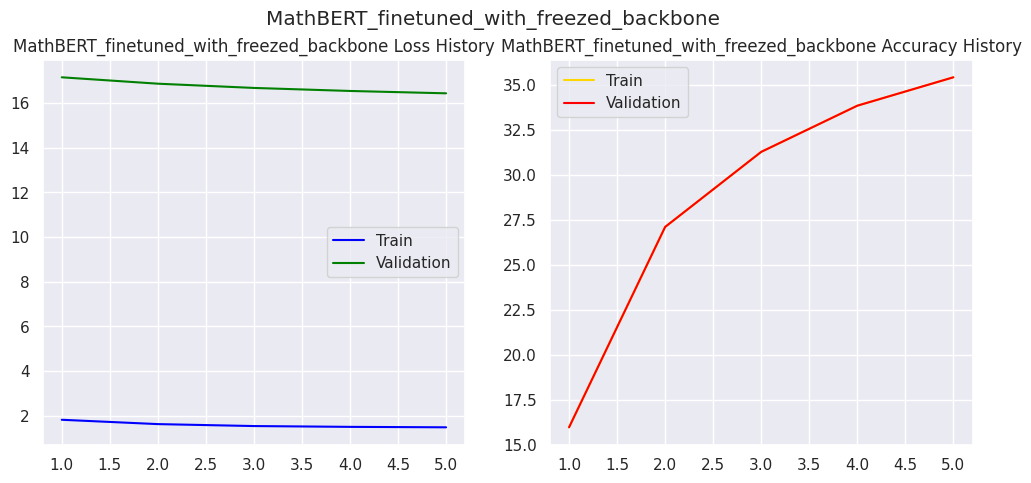

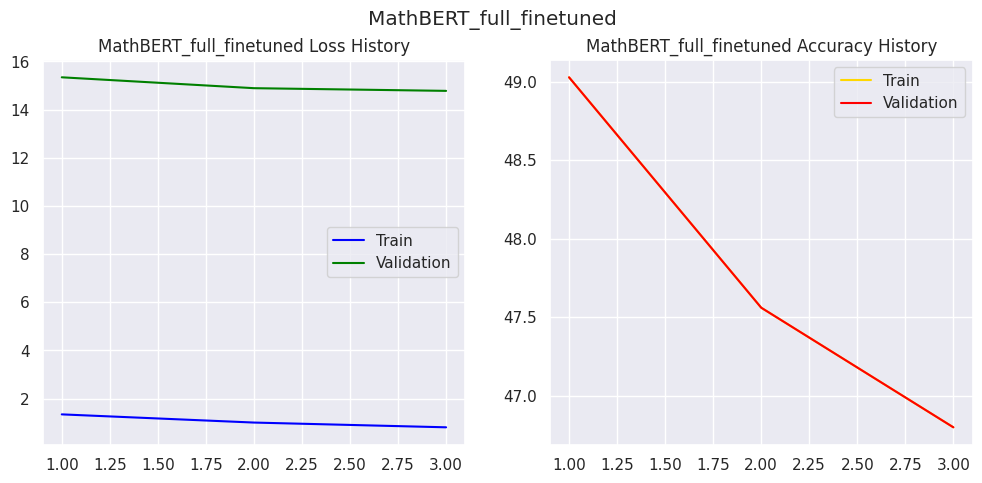

In [ ]:
# Plot loss and accuracy history
plot_loss_accuracy(MathBERT_l_history_with_freezed_backbone, MathBERT_a_history_with_freezed_backbone, "MathBERT_finetuned_with_freezed_backbone")
plot_loss_accuracy(MathBERT_l_history_full_finetuned, MathBERT_a_history_full_finetuned, "MathBERT_full_finetuned")

In [ ]:
print("mathBERT_finetuned_with_freezed_backbone:")
eval_n_print_batch(mathBERT_finetuned_with_freezed_backbone, MathBERT_test_loader)
print()
print("mathBERT_full_finetuned:")
eval_n_print_batch(mathBERT_full_finetuned, MathBERT_test_loader)


mathBERT_finetuned_with_freezed_backbone:
Predictions: ['Теория чисел' 'Теория чисел' 'Теория чисел' 'Теория чисел'
 'Теория чисел' 'Теория чисел' 'Теория чисел' 'Теория чисел'
 'Теория чисел' 'Теория чисел' 'Теория чисел' 'Теория чисел'
 'Теория чисел' 'Теория чисел' 'Теория чисел' 'Теория чисел']
Labels: ['Дирихле' 'Теория чисел' 'Многочлен' 'Многочлен' 'Дирихле' 'Графы'
 'Теория чисел' 'Геометрия' 'Теория чисел' 'Геометрия' 'Теория чисел'
 'Теория чисел' 'Теория чисел' 'Теория чисел' 'Многочлен' 'Комбинаторика']

mathBERT_full_finetuned:
Predictions: ['Теория чисел' 'Графы' 'Теория чисел' 'Многочлен' 'Теория чисел' 'Графы'
 'Теория чисел' 'Геометрия' 'Теория чисел' 'Геометрия' 'Теория чисел'
 'Теория чисел' 'Теория чисел' 'Теория чисел' 'Теория чисел'
 'Теория чисел']
Labels: ['Дирихле' 'Теория чисел' 'Многочлен' 'Многочлен' 'Дирихле' 'Графы'
 'Теория чисел' 'Геометрия' 'Теория чисел' 'Геометрия' 'Теория чисел'
 'Теория чисел' 'Теория чисел' 'Теория чисел' 'Многочлен' 'Комбинаторика

### Задание 6 (1 балл)

Напишите функцию для отрисовки карт внимания первого слоя для моделей из задания

In [ ]:
def draw_first_layer_attention_maps(model: TransformerClassificationModel, checkpoint, text: str):
    tokenizer = AutoTokenizer.from_pretrained(checkpoint, padding=True, truncation=True, max_length=512)
    inputs = tokenizer(text, return_tensors="pt")


    model.eval()
    model.backbone.config.output_attentions = True

    with torch.no_grad():
      input_ids, token_type_ids, attention_mask = inputs['input_ids'], inputs['token_type_ids'], inputs['attention_mask']
      input_ids = input_ids.to(device)
      token_type_ids = token_type_ids.to(device)
      attention_mask = attention_mask.to(device)

      outputs = model.backbone(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)


    attentions = outputs[-1]
    first_layer_attentions = attentions[0]


    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
    num_heads = first_layer_attentions.size(1)
    for head_id in  range(num_heads):
        attention = first_layer_attentions[0, head_id].detach().cpu().numpy()

        plt.figure(figsize=(8, 8))
        sns.heatmap(attention, annot=False, cmap='viridis',xticklabels=tokens, yticklabels=tokens)
        plt.title(f"Attention Map of Model {checkpoint} - Layer 1 - Head {head_id} ")
        plt.show()

    model.backbone.config.output_attentions = False

### Задание 8 (1 балл)

Сделайте карты внимания для дообученных моделей.

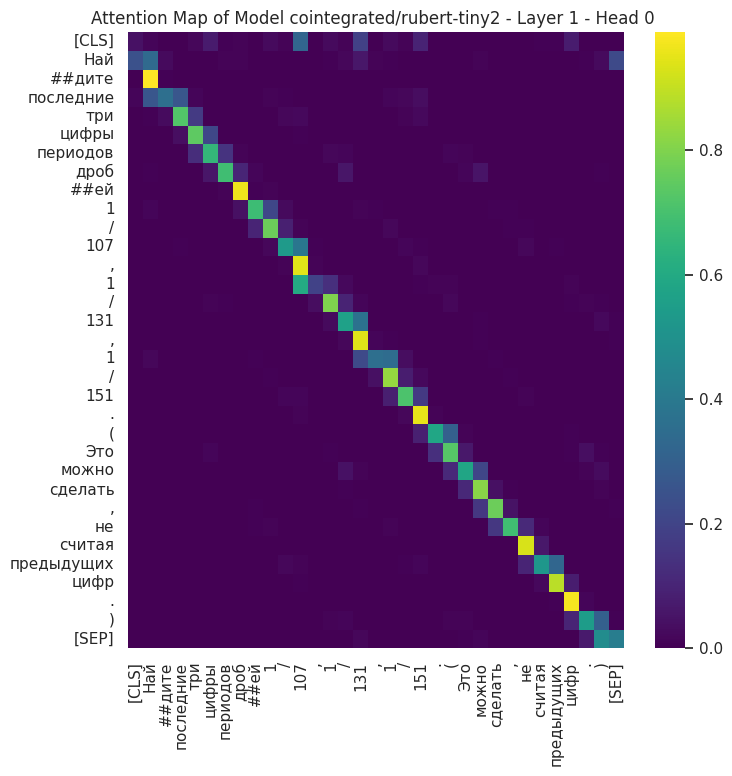

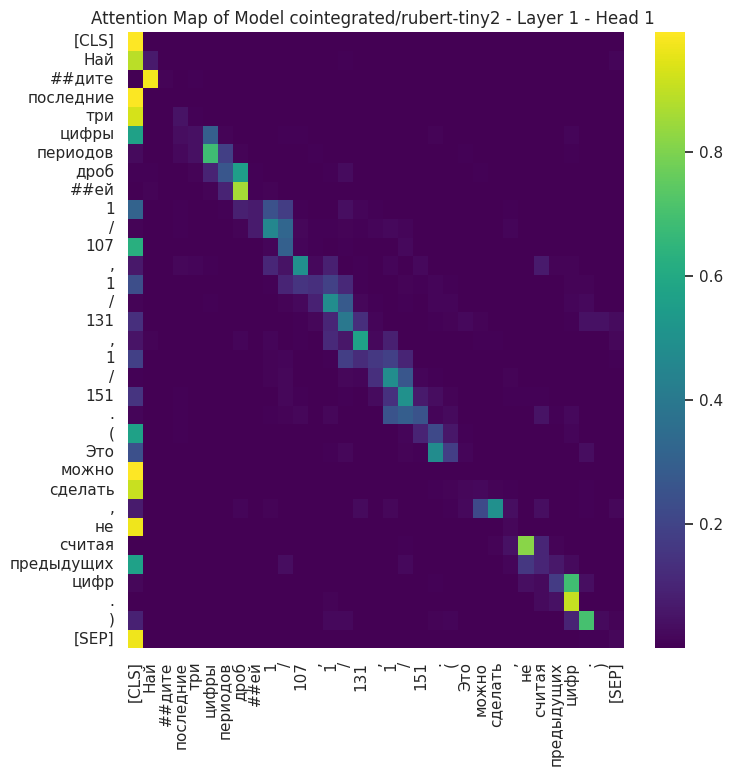

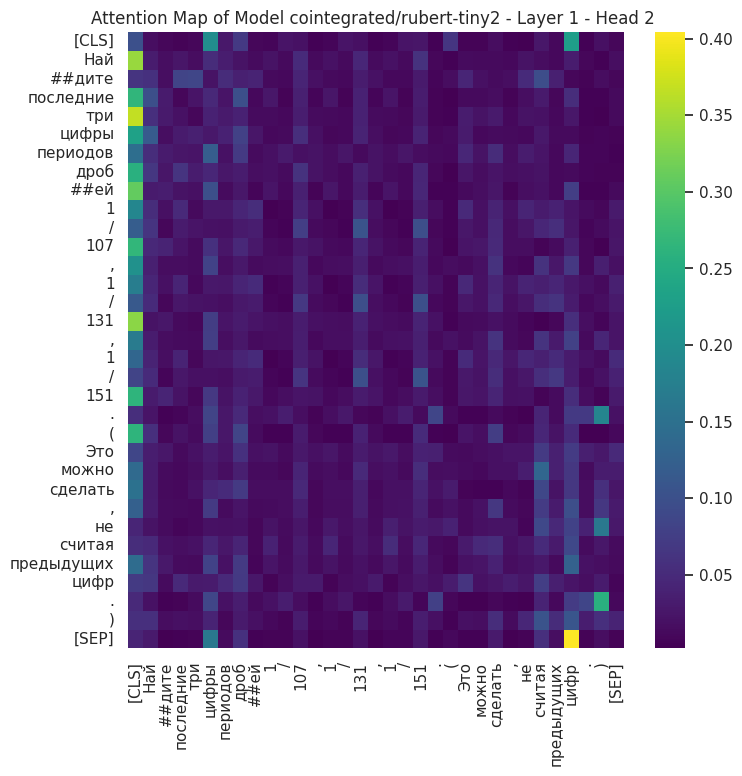

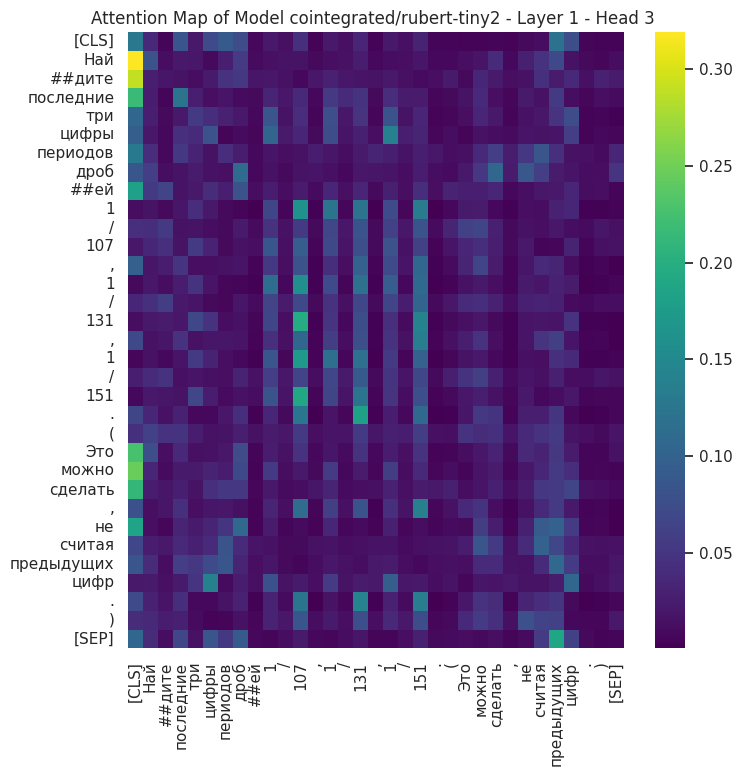

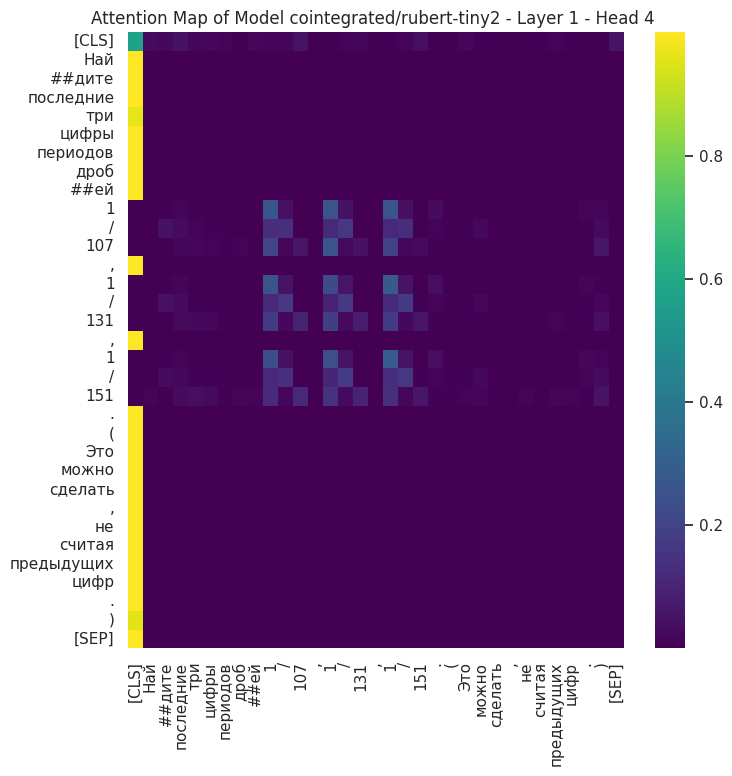

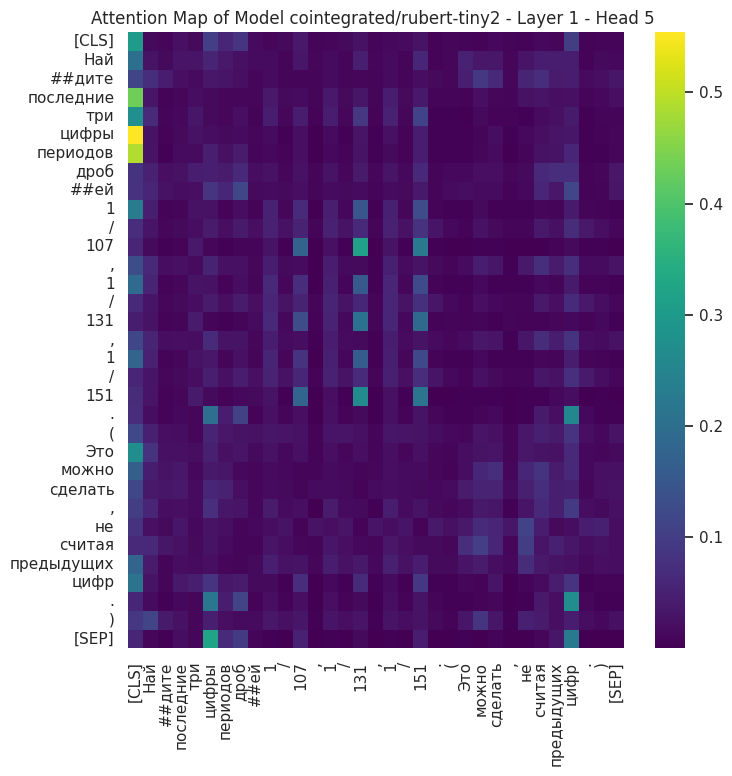

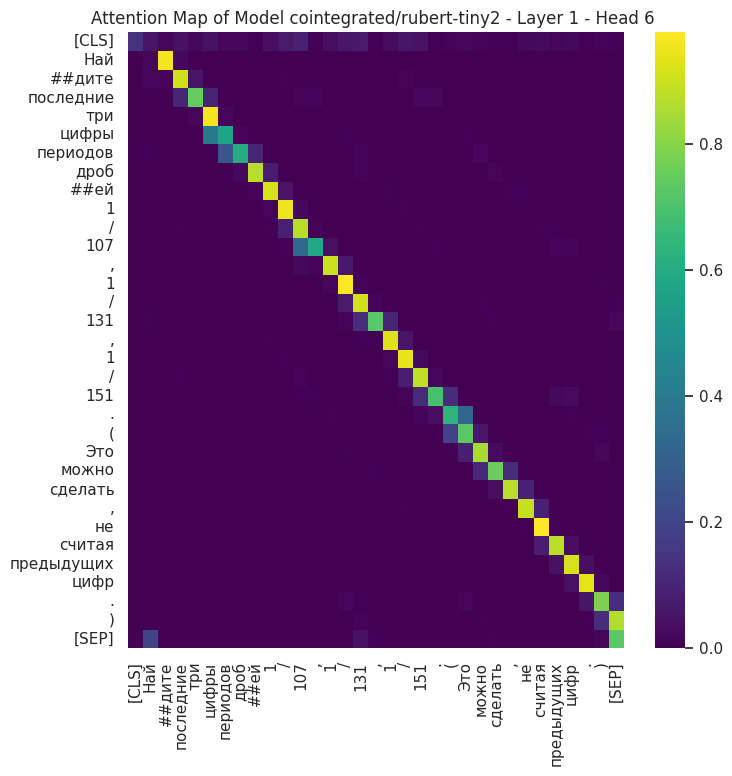

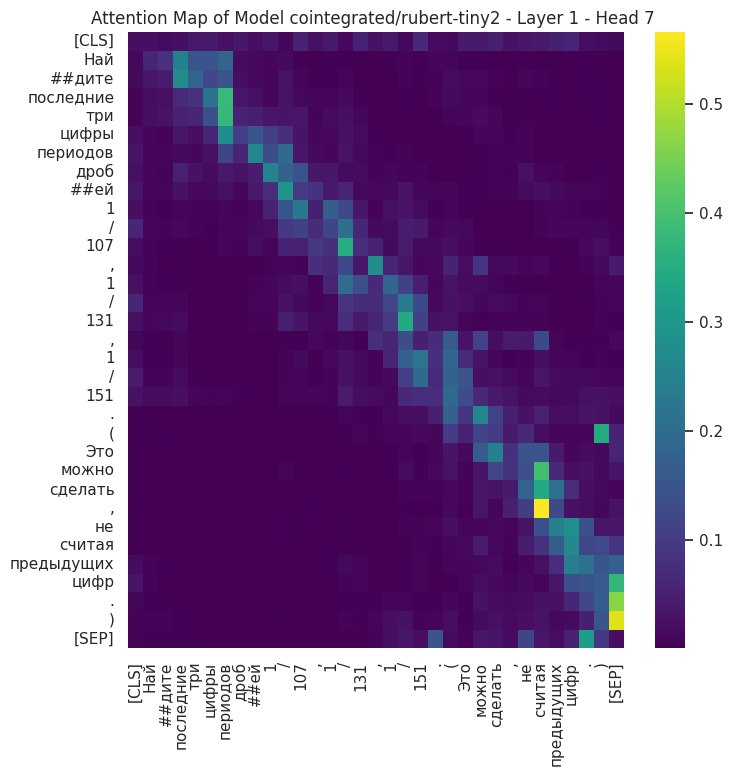

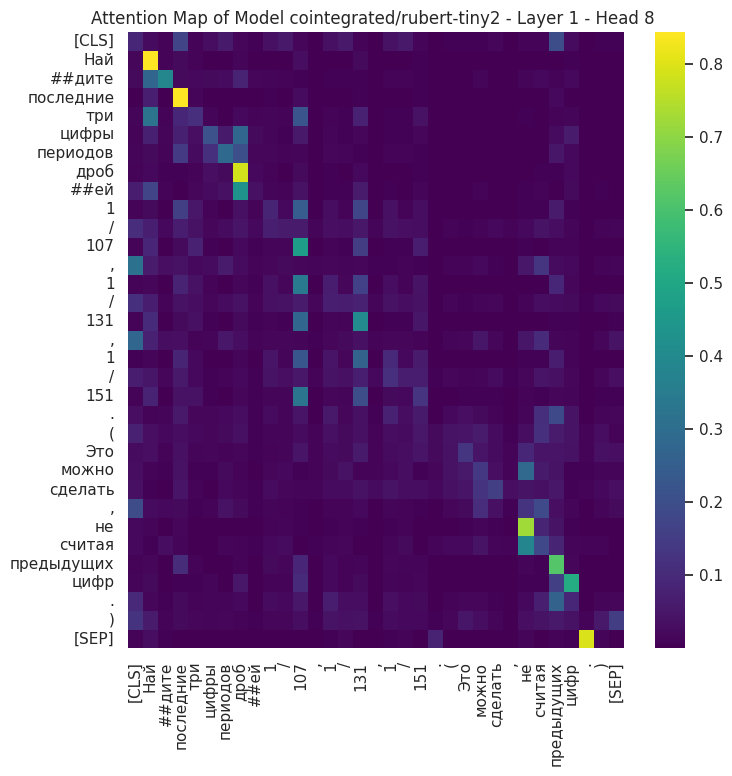

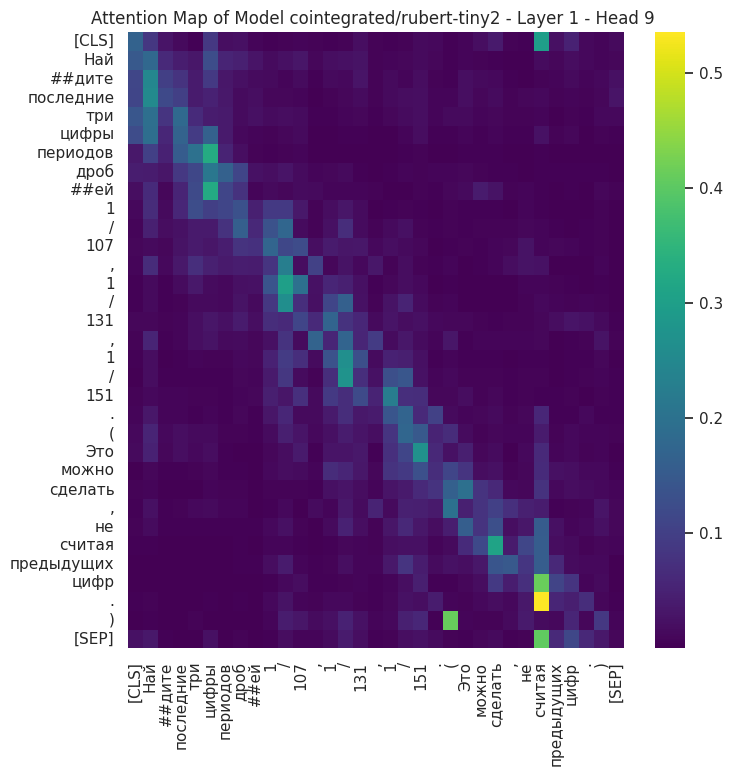

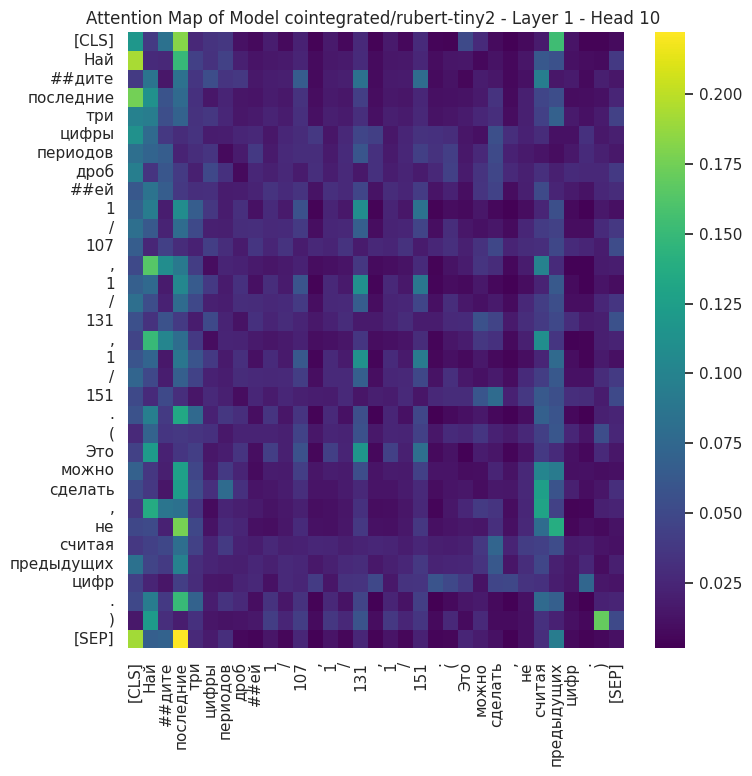

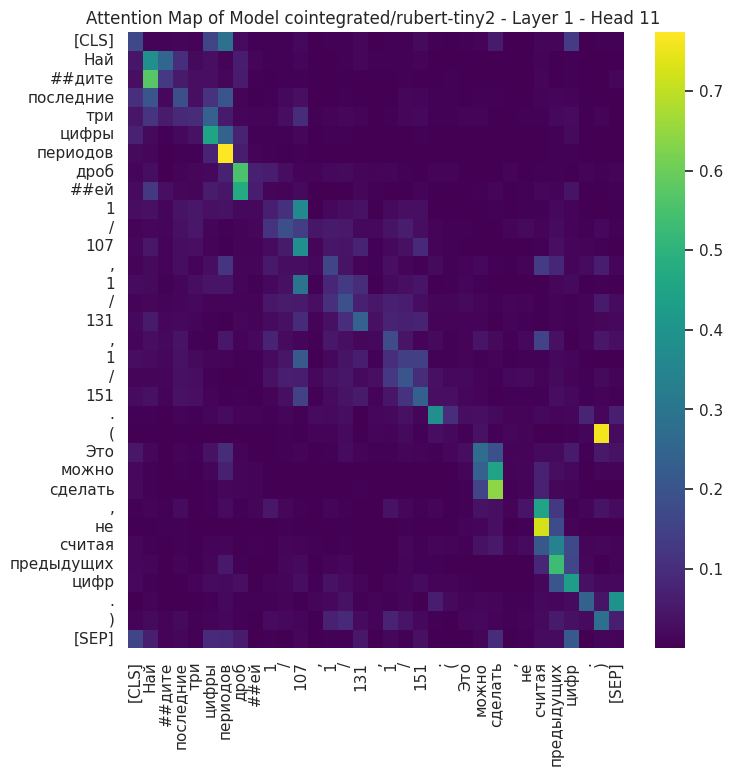

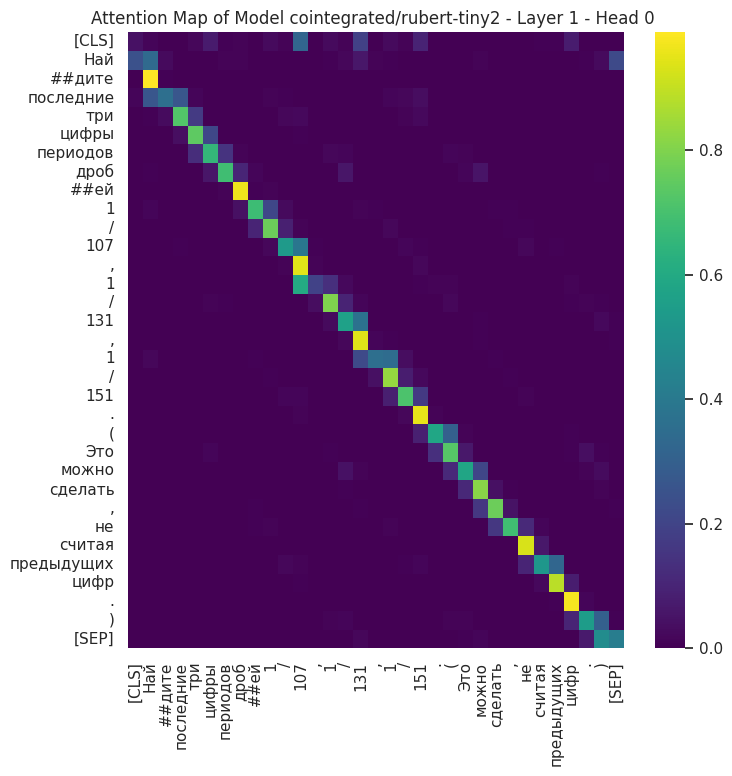

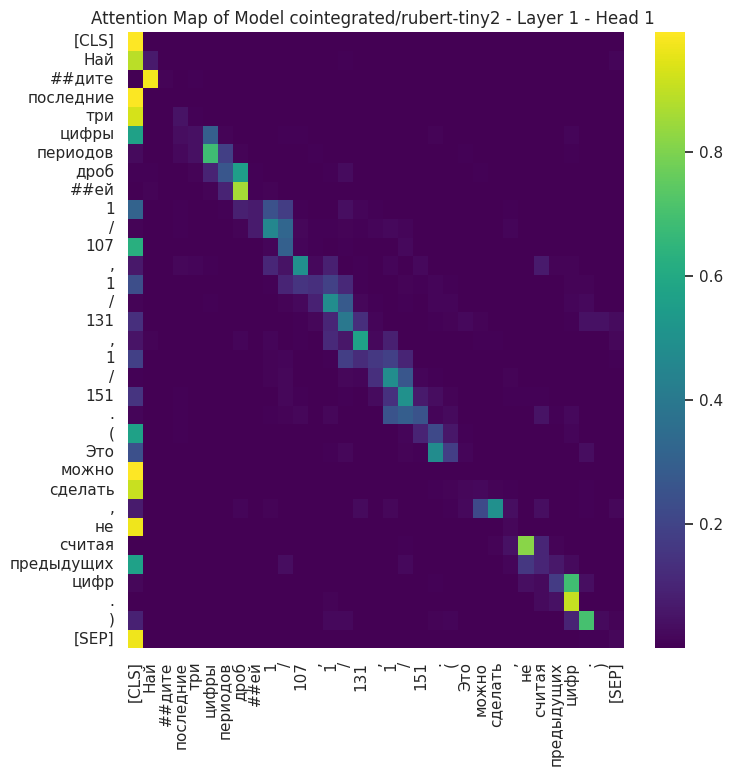

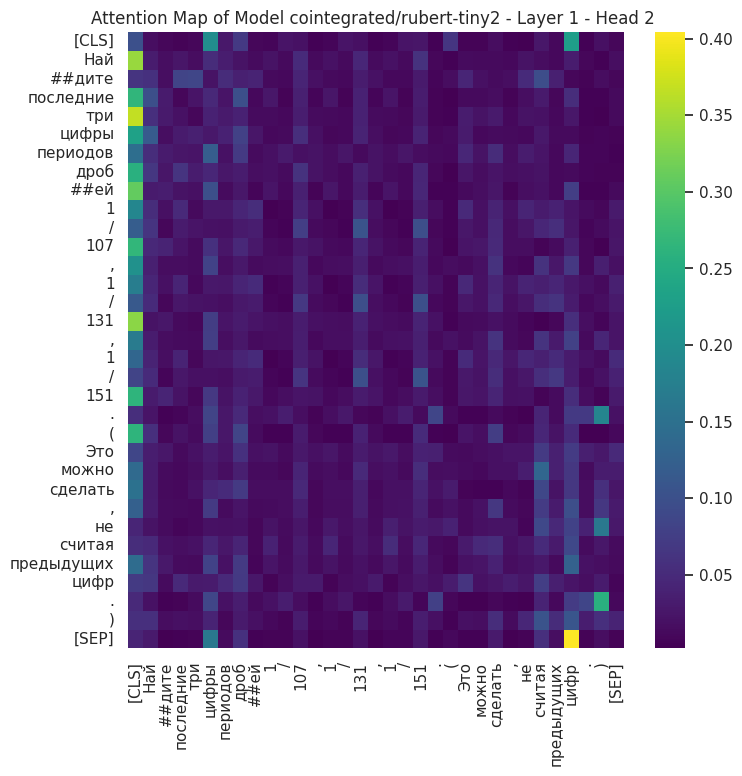

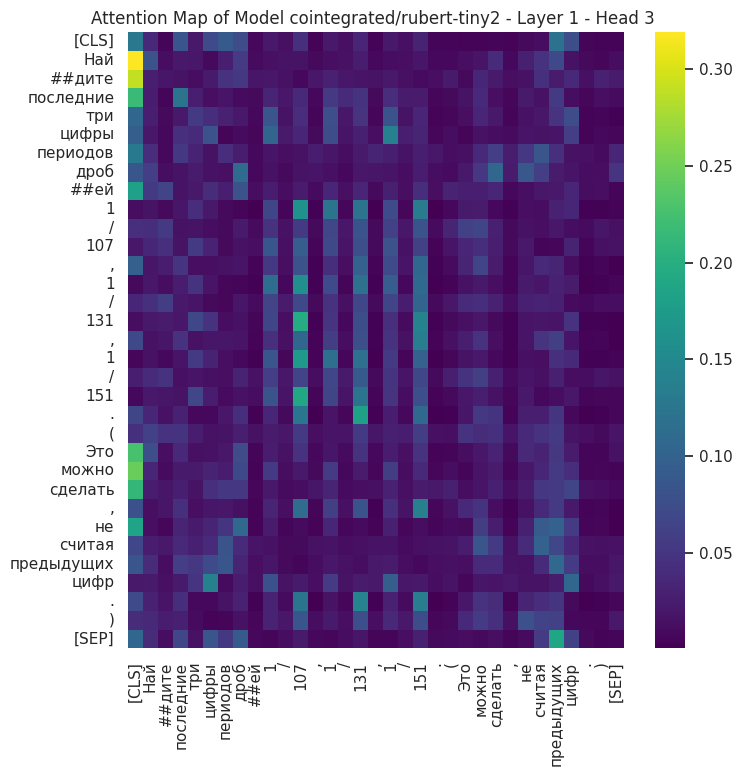

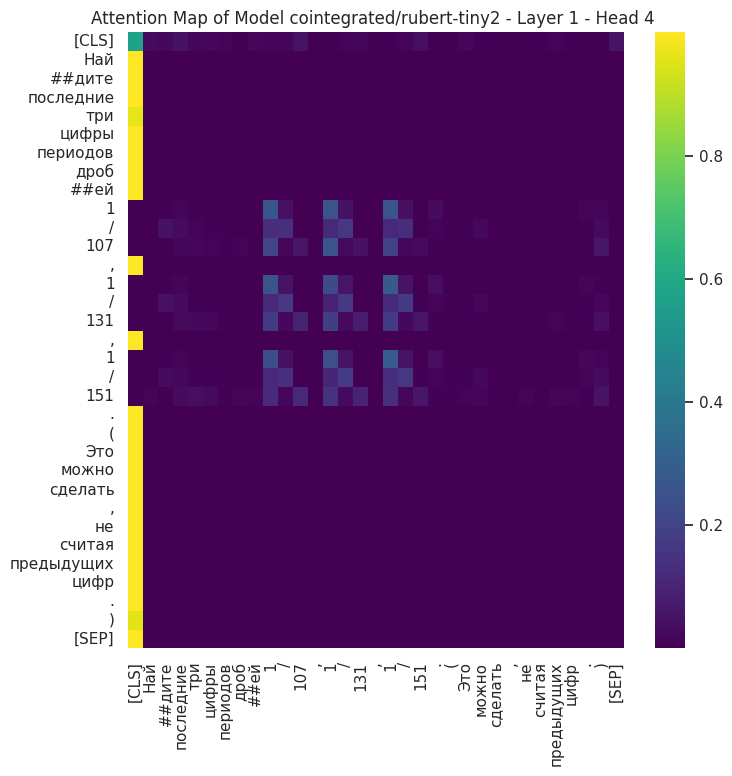

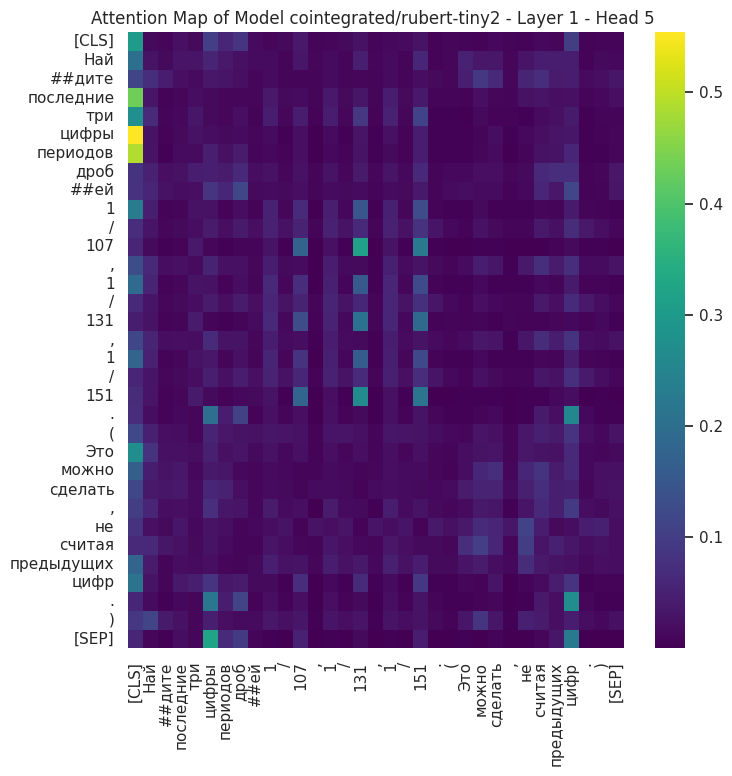

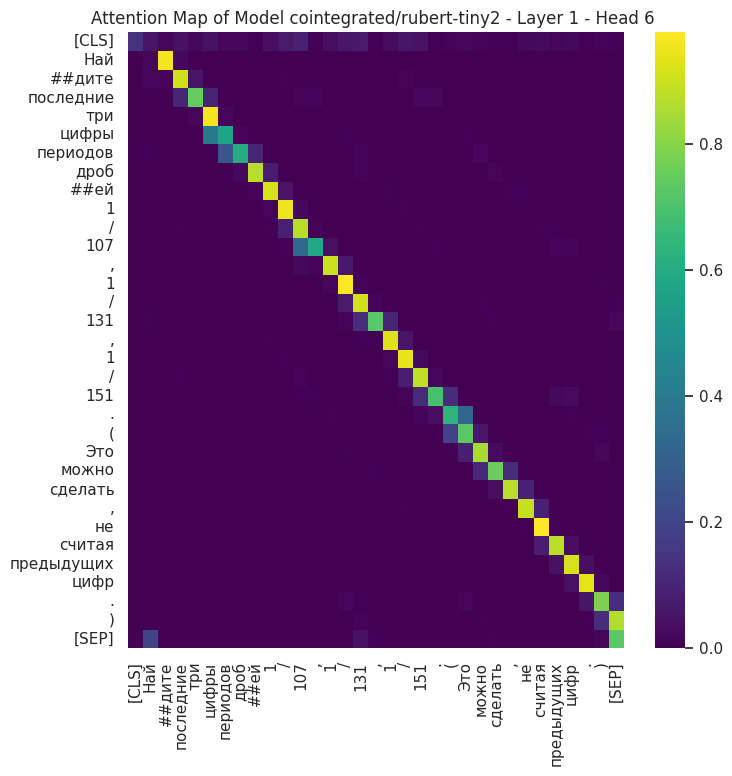

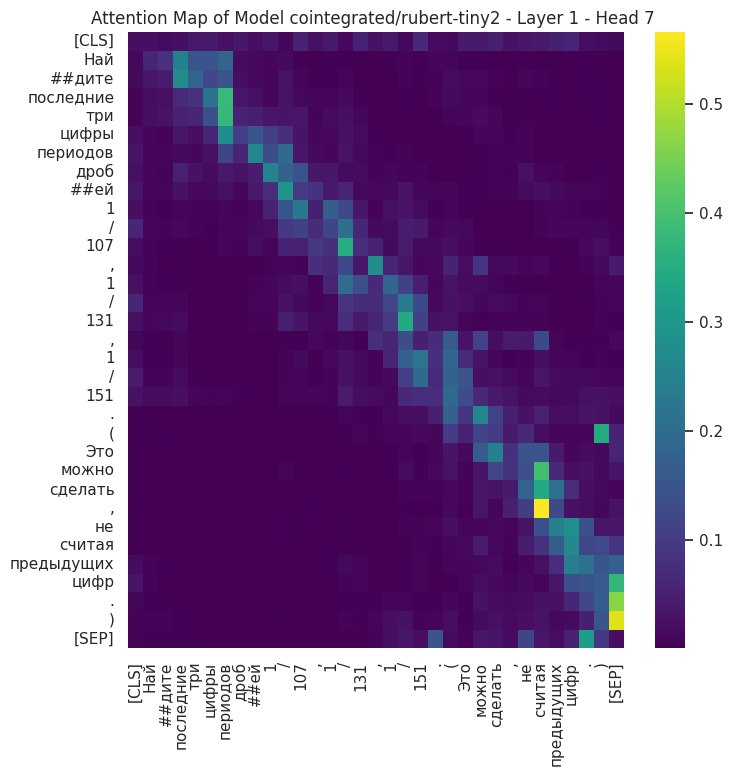

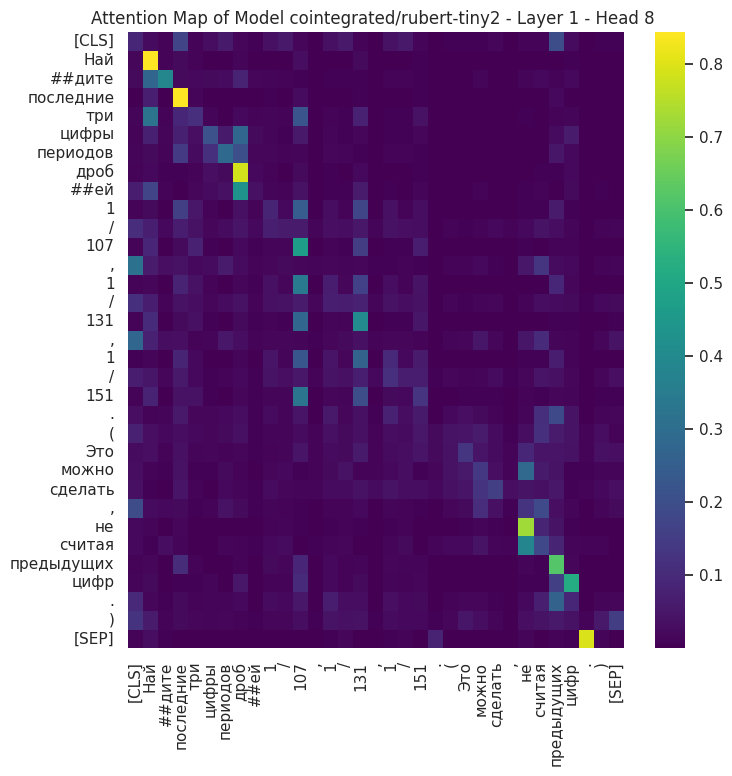

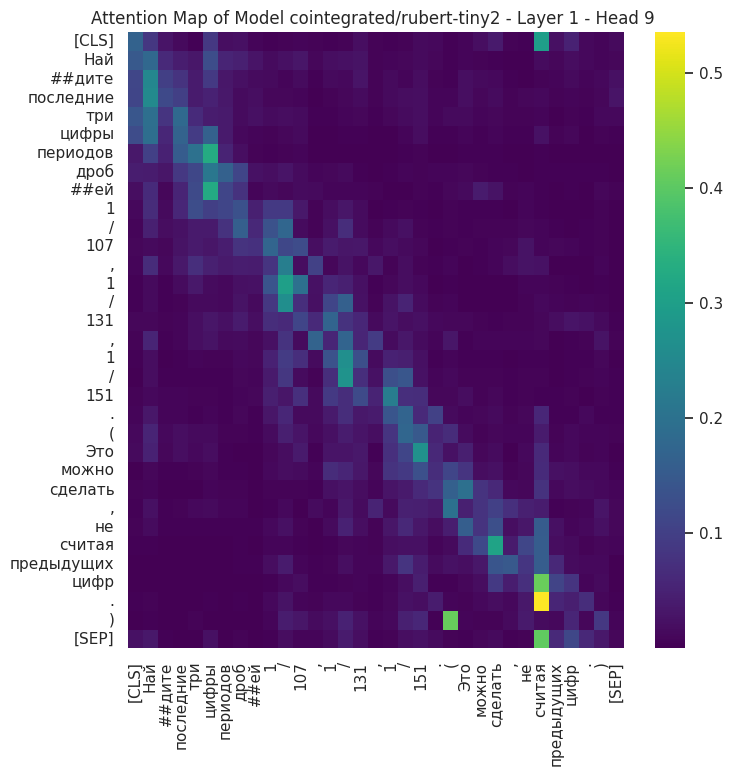

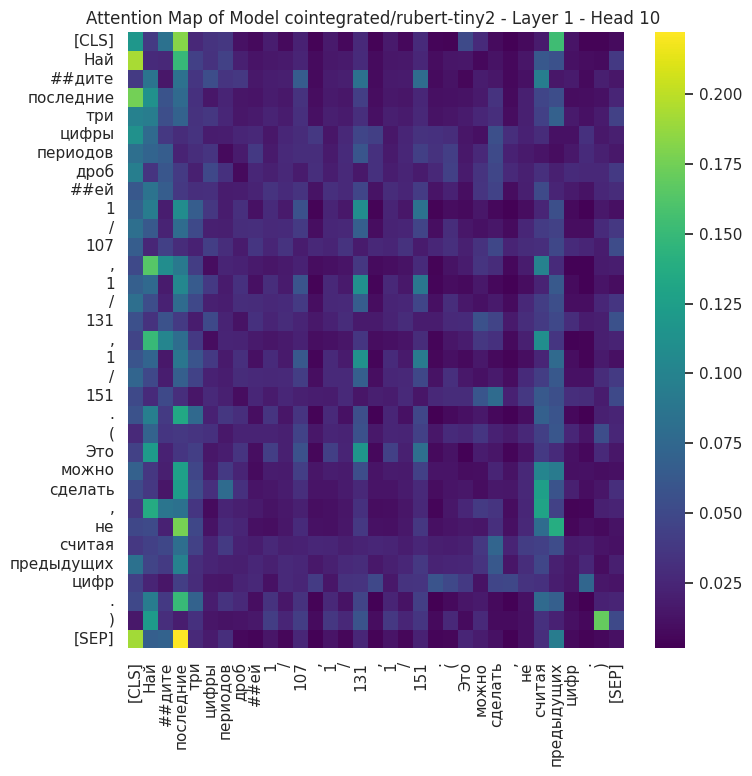

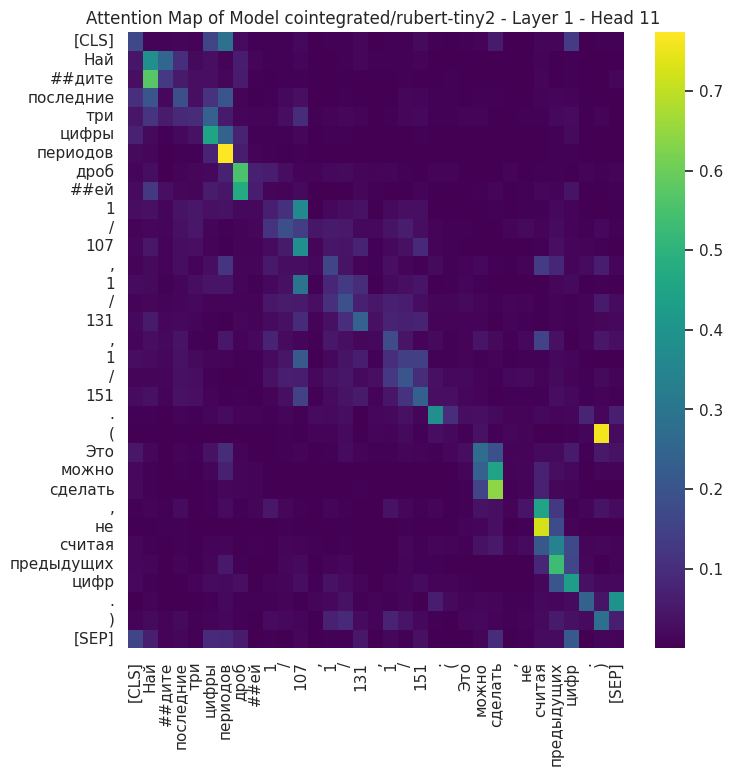

In [ ]:
draw_first_layer_attention_maps(rubert_tiny_finetuned_with_freezed_backbone, rubert_tiny_checkpoint, math_problem)
draw_first_layer_attention_maps(rubert_tiny_full_finetuned, rubert_tiny_checkpoint, math_problem)


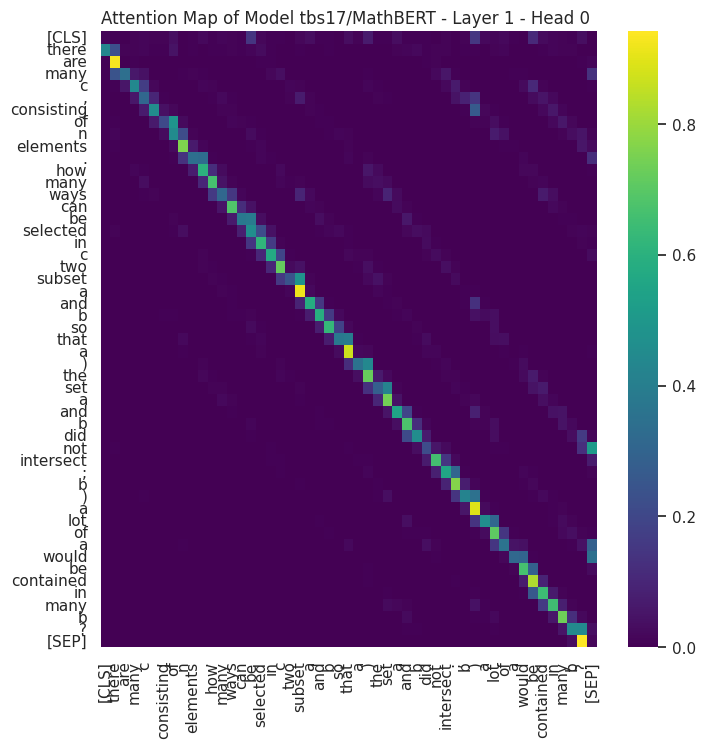

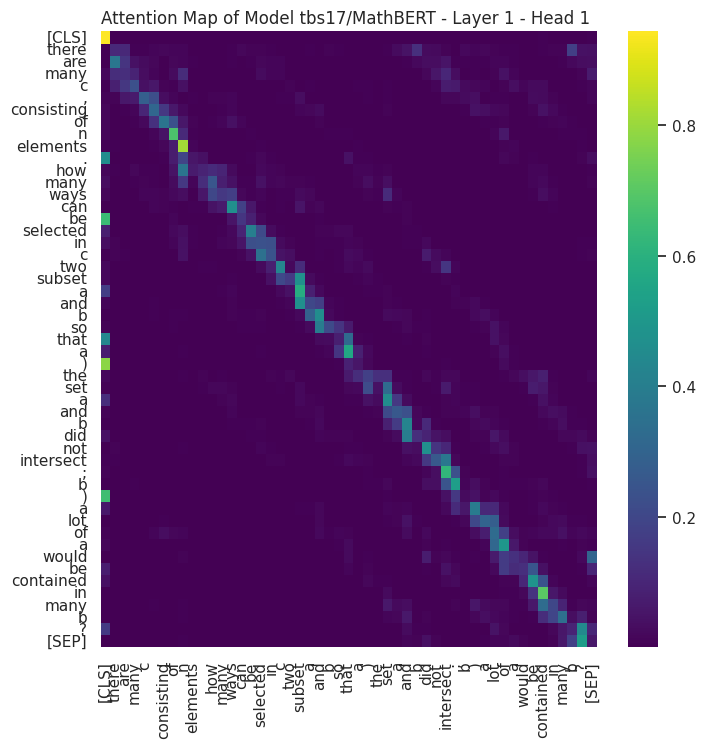

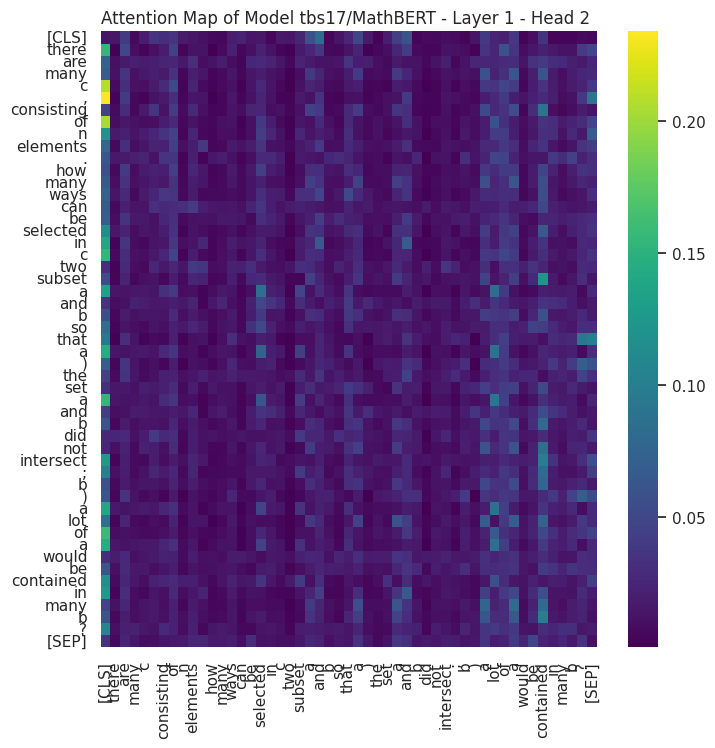

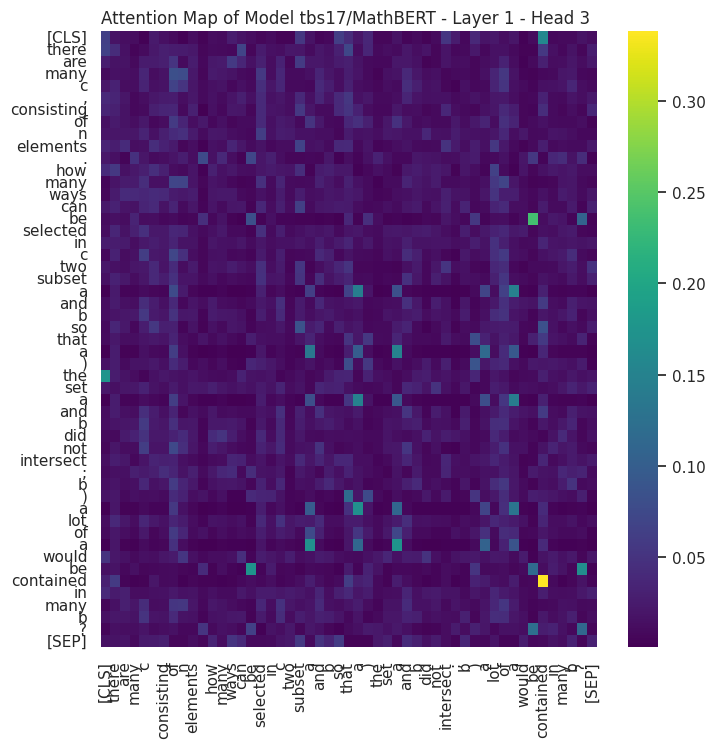

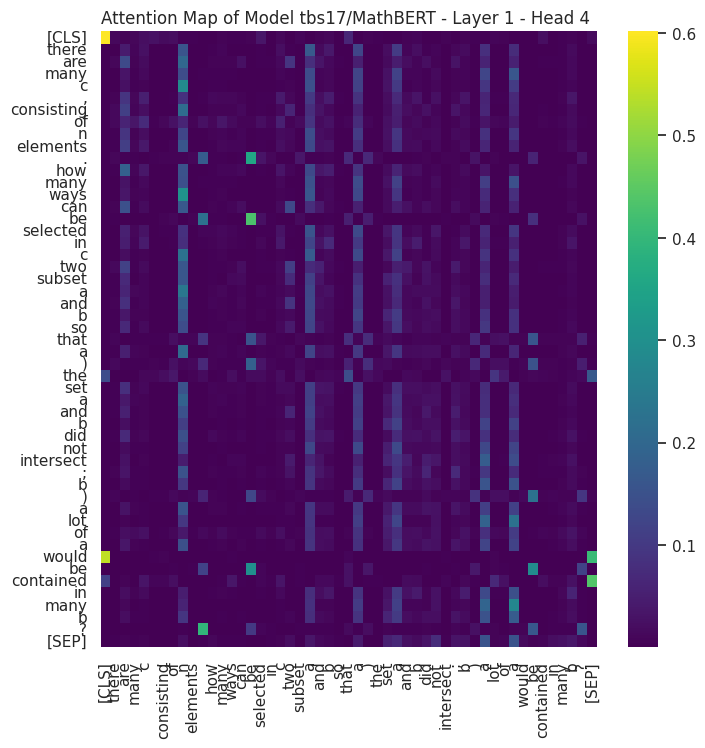

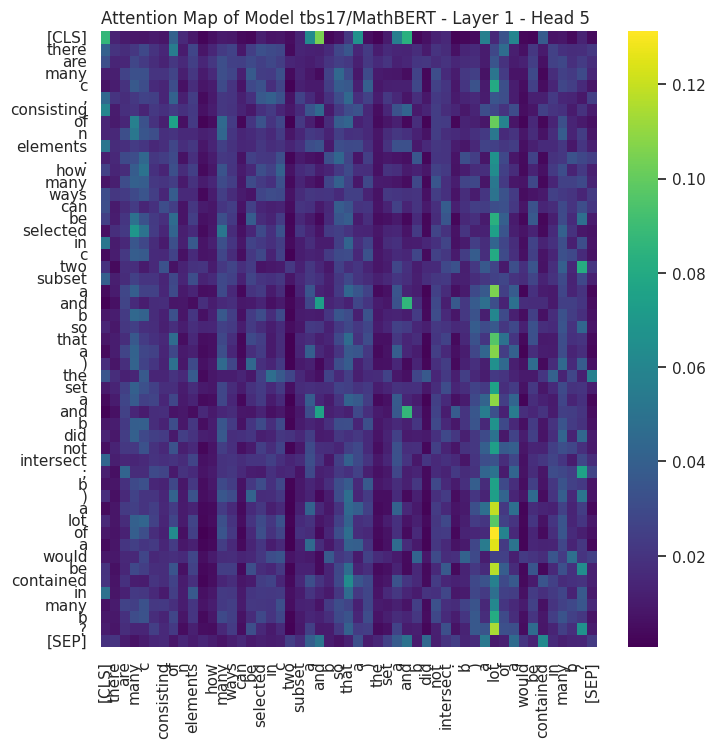

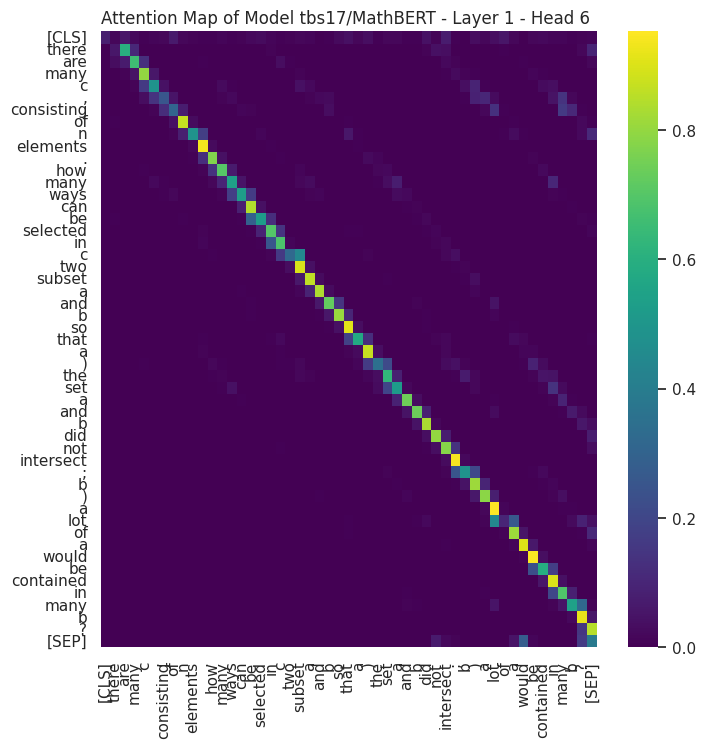

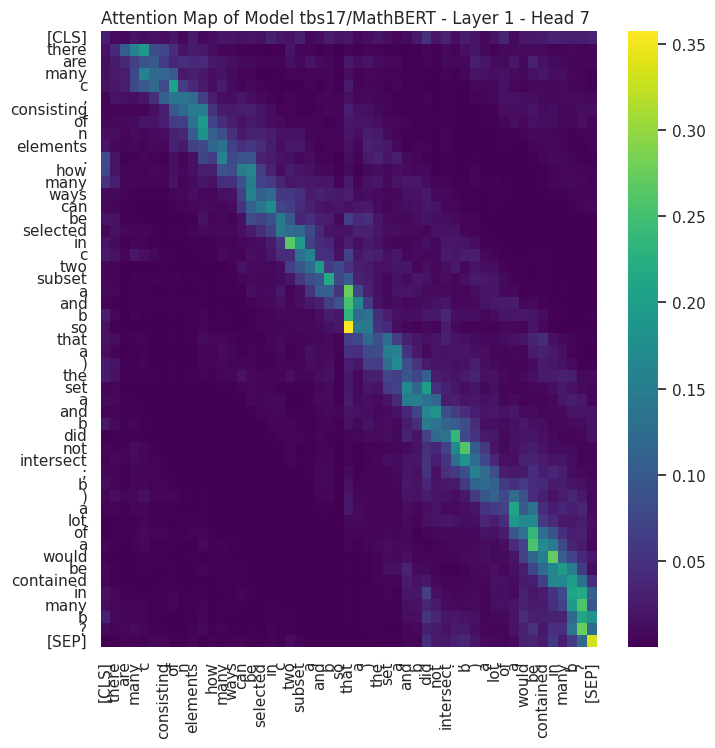

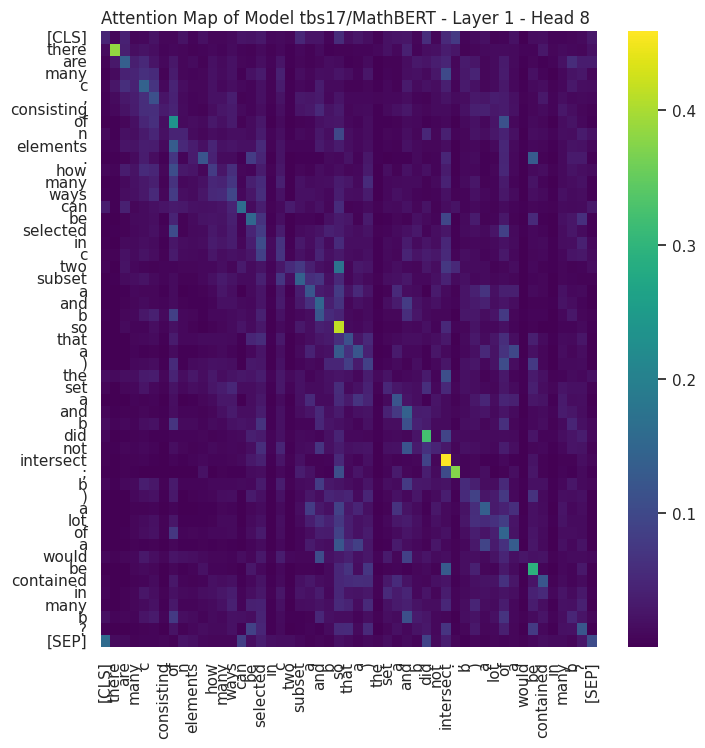

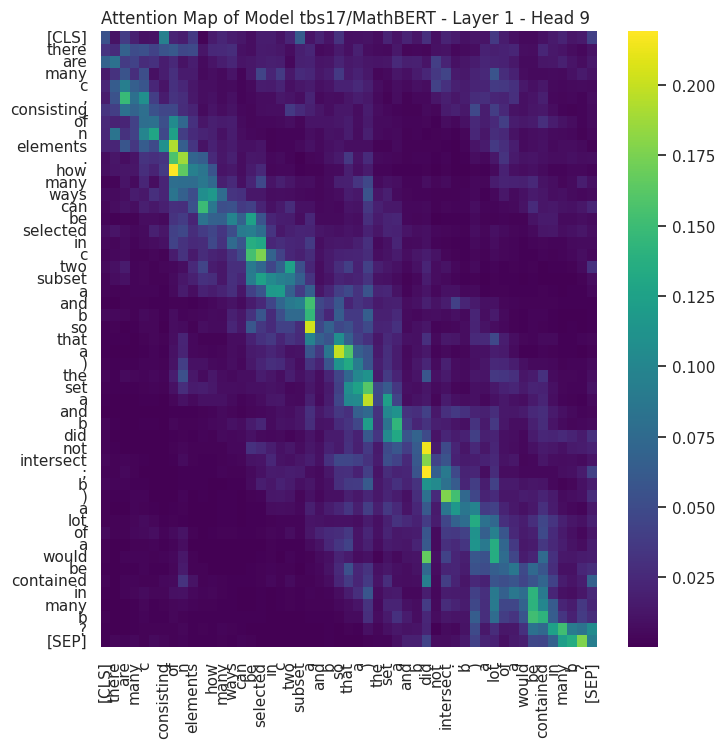

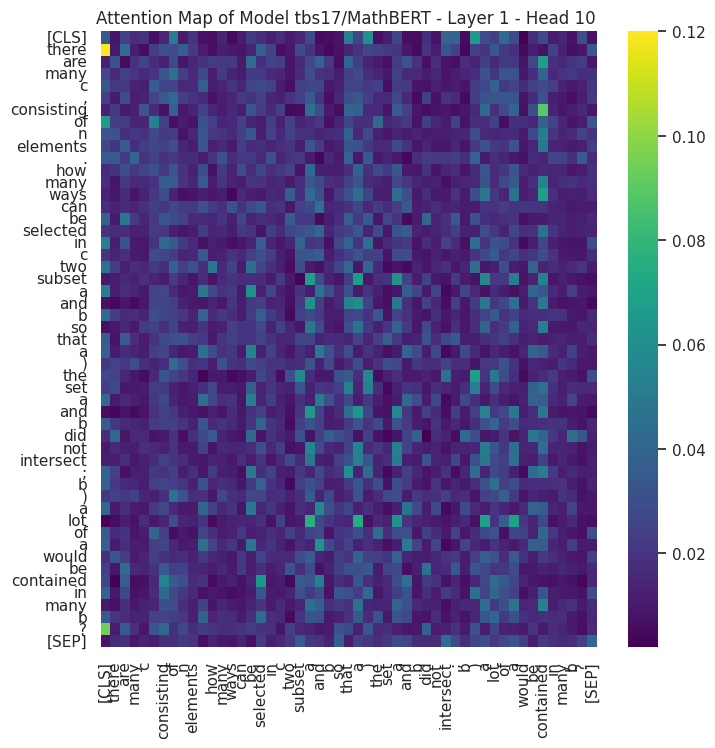

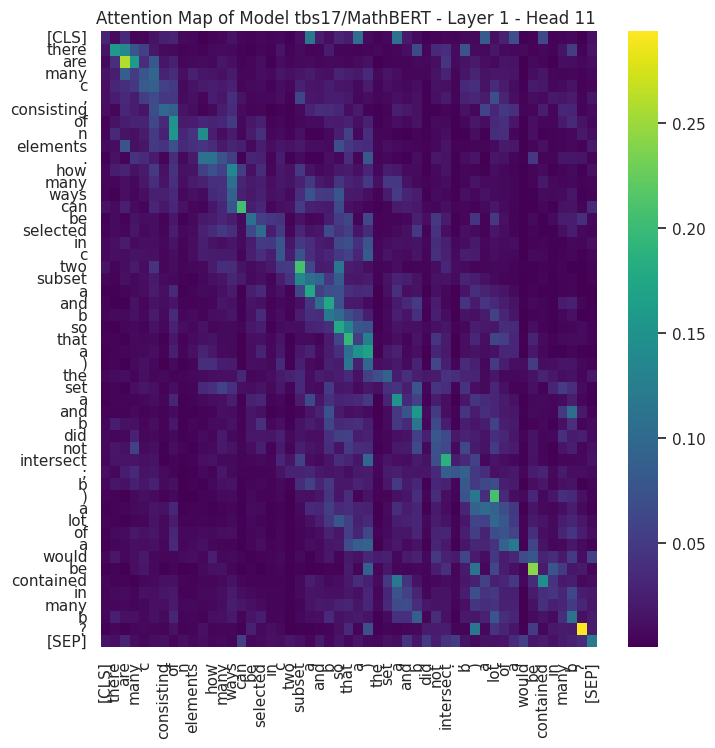

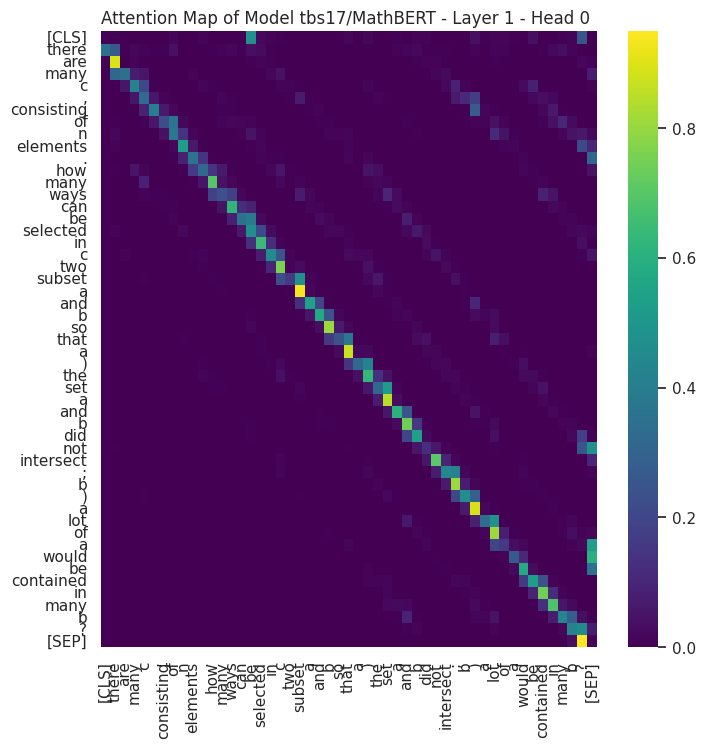

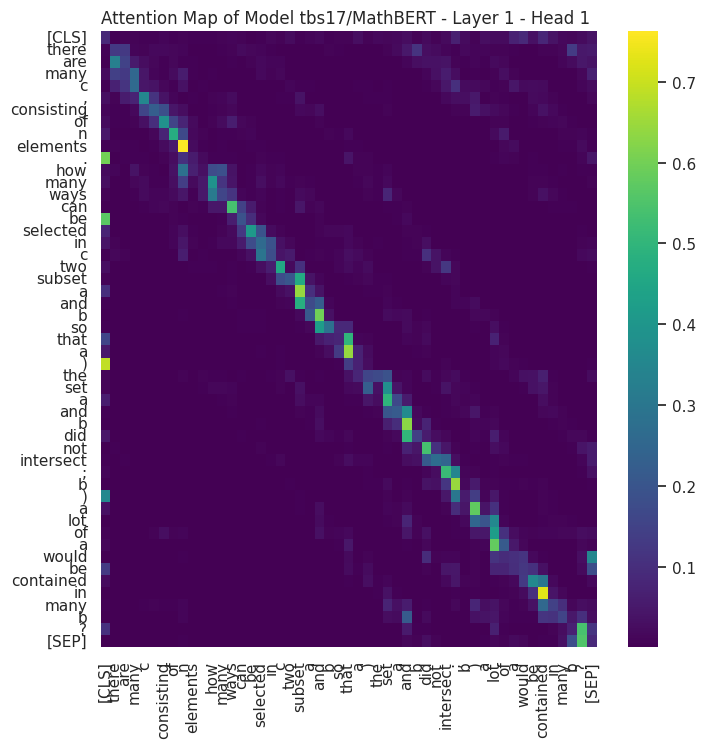

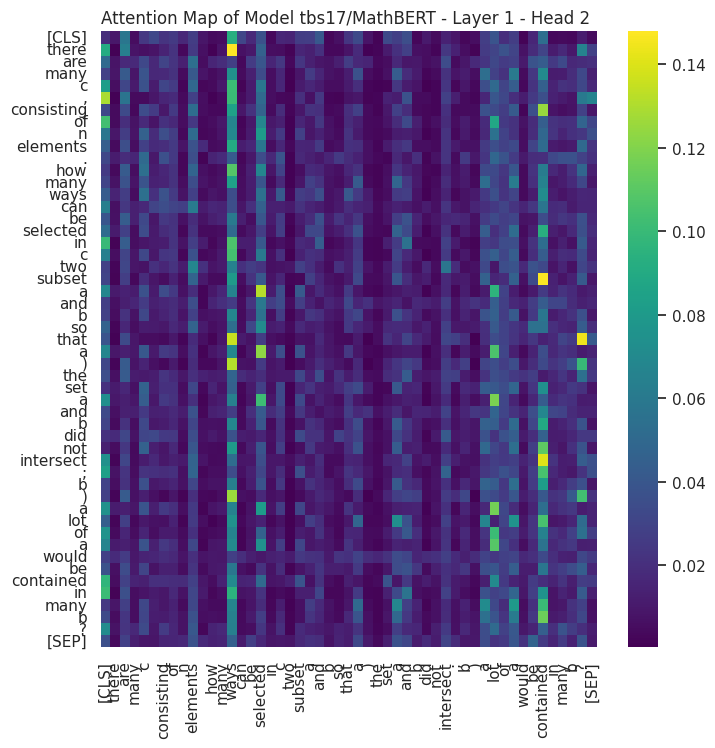

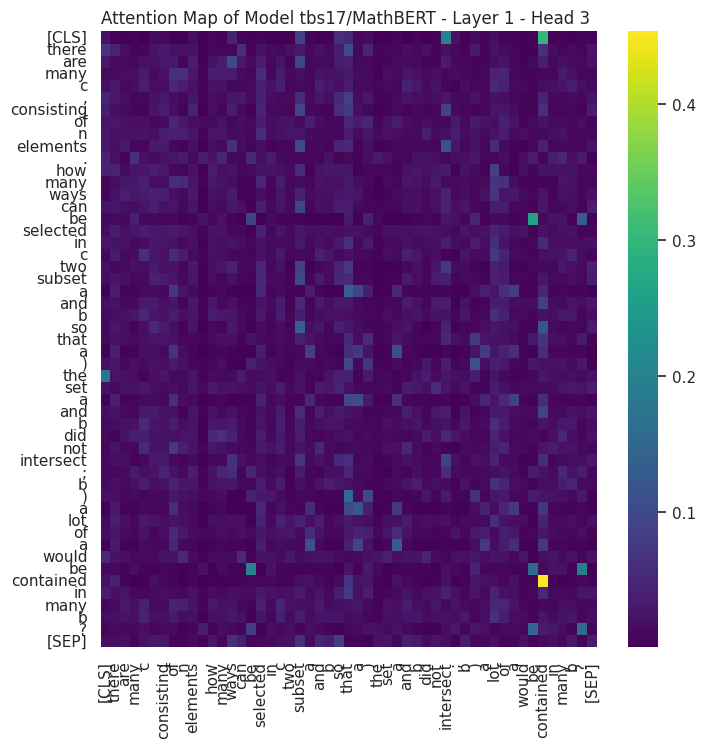

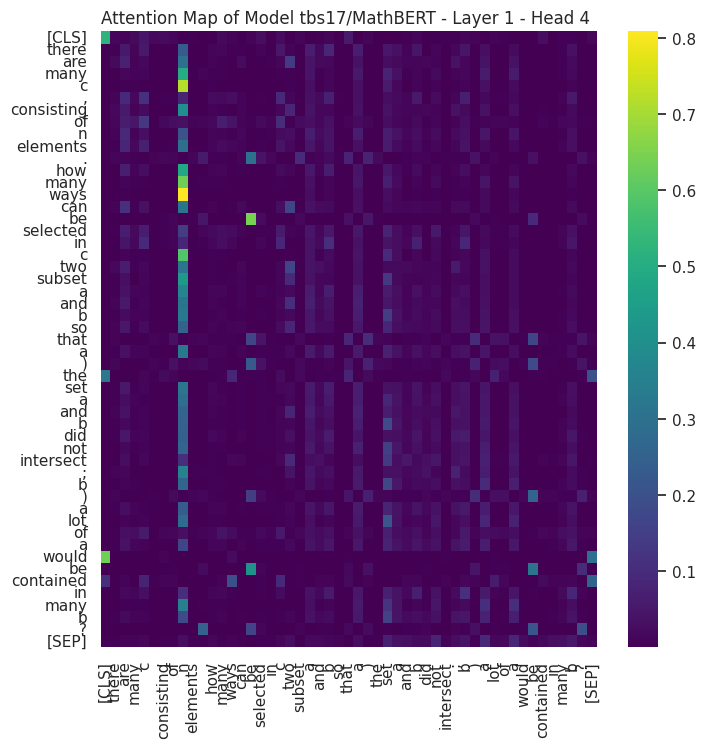

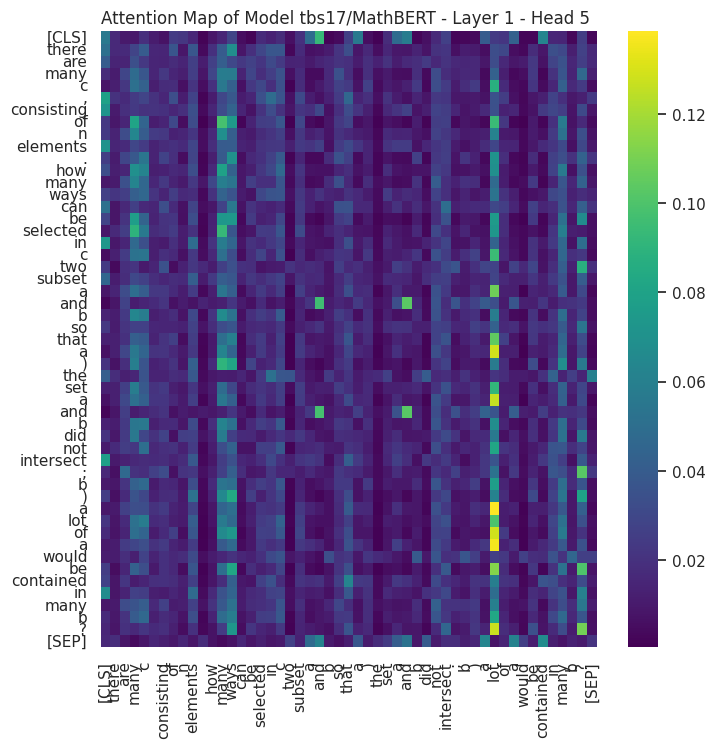

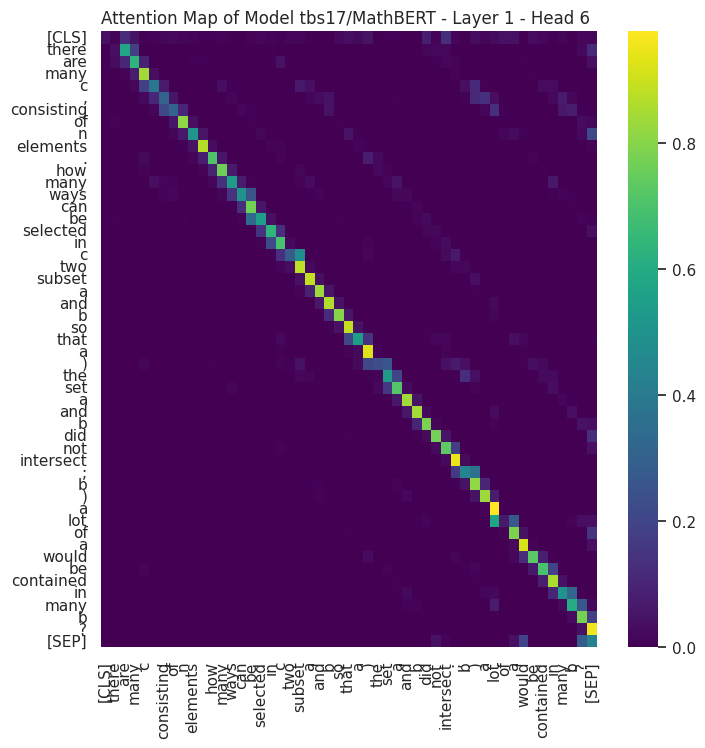

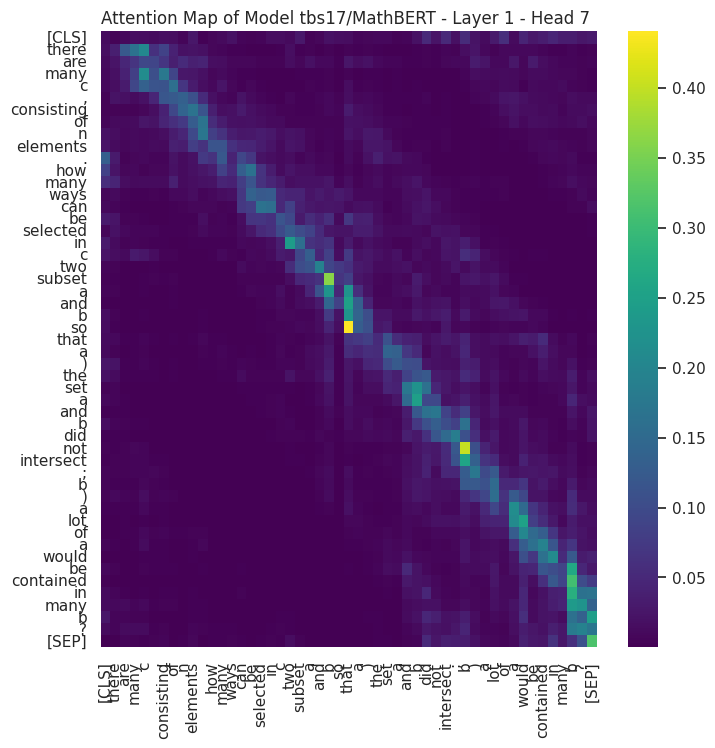

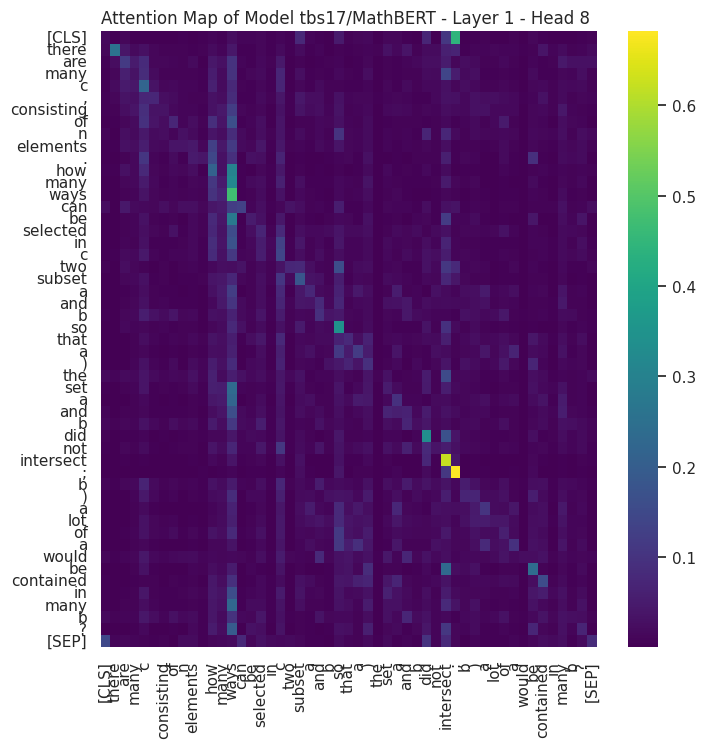

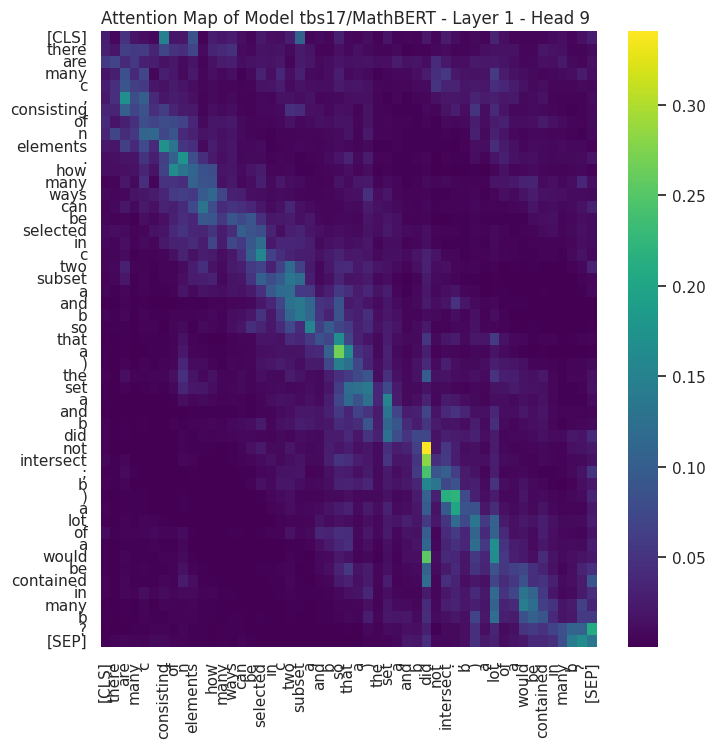

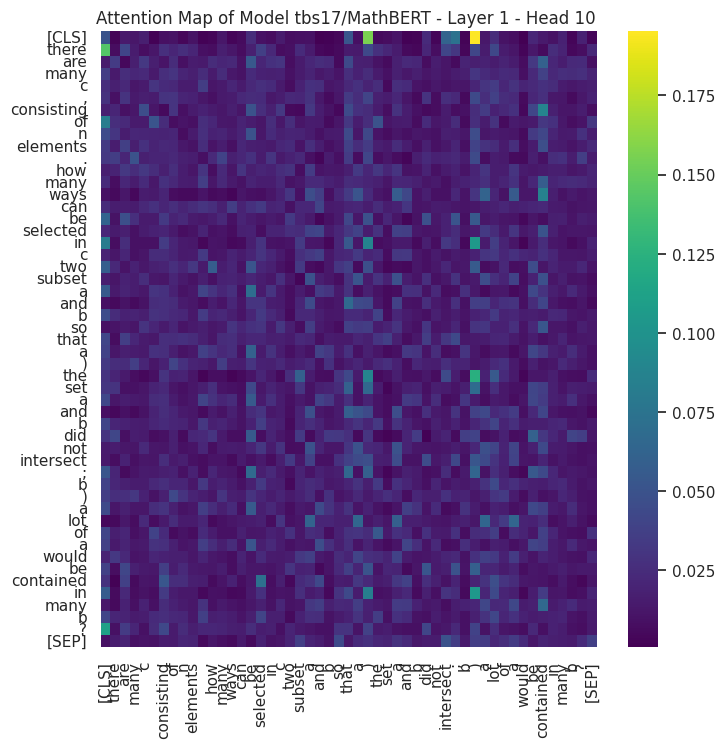

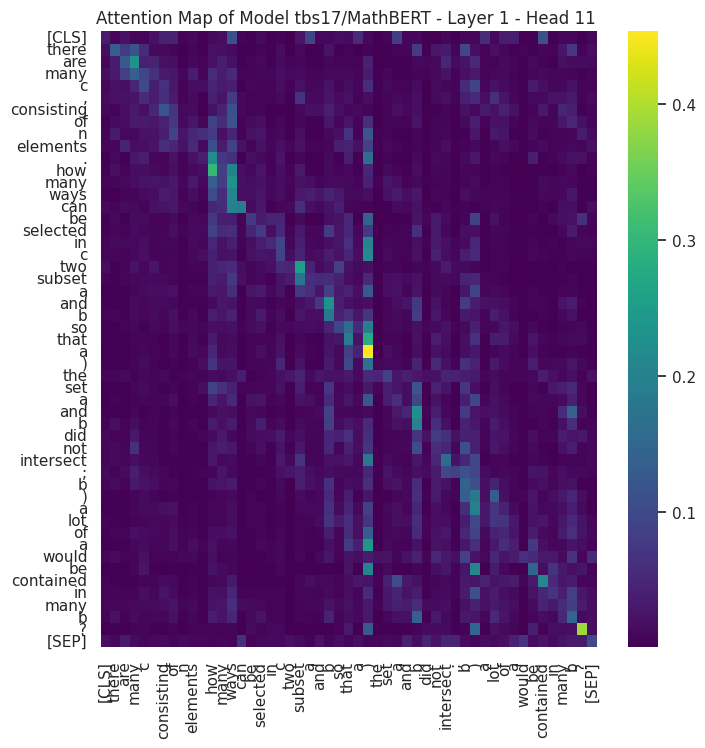

In [ ]:
draw_first_layer_attention_maps(mathBERT_finetuned_with_freezed_backbone, mathBERT_checkpoint, math_problem_en)
draw_first_layer_attention_maps(mathBERT_full_finetuned, mathBERT_checkpoint, math_problem_en)


### Задание 7 (1 балл)

Проведите инференс для всех моделей **ДО ДООБУЧЕНИЯ** на 2-3 текстах из датасета. Посмотрите на головы Attention первого слоя в каждой модели на выбранных текстах (отрисуйте их отдельно).

Попробуйте их проинтерпретировать. Какие связи улавливают карты внимания? (если в модели много голов Attention, то проинтерпретируйте наиболее интересные)

In [ ]:
RT_checkpoint = 'cointegrated/rubert-tiny2'
model_RT = TransformerClassificationModel(RT_checkpoint).to(device)
eval_n_print_batch(model_RT, test_loader)

MATHBERT_checkpoint = 'tbs17/MathBERT'
model_MATHBERT = TransformerClassificationModel(MATHBERT_checkpoint).to(device)
eval_n_print_batch(model_MATHBERT, MathBERT_test_loader)

Predictions: ['Инвариант' 'Комбинаторика' 'Инвариант' 'Теория чисел' 'Инвариант'
 'Дирихле' 'Дирихле' 'Дирихле' 'Графы' 'Инвариант' 'Теория чисел'
 'Дирихле' 'Дирихле' 'Дирихле' 'Дирихле' 'Дирихле']
Labels: ['Теория чисел' 'Графы' 'Многочлен' 'Теория чисел' 'Дирихле'
 'Теория чисел' 'Геометрия' 'Графы' 'Комбинаторика' 'Дирихле'
 'Комбинаторика' 'Теория чисел' 'Комбинаторика' 'Графы' 'Комбинаторика'
 'Дирихле']


pytorch_model.bin:   0%|          | 0.00/441M [00:00<?, ?B/s]

Predictions: ['Теория чисел' 'Комбинаторика' 'Комбинаторика' 'Комбинаторика'
 'Комбинаторика' 'Комбинаторика' 'Комбинаторика' 'Инвариант'
 'Комбинаторика' 'Комбинаторика' 'Комбинаторика' 'Комбинаторика'
 'Комбинаторика' 'Теория чисел' 'Комбинаторика' 'Геометрия']
Labels: ['Дирихле' 'Теория чисел' 'Многочлен' 'Многочлен' 'Дирихле' 'Графы'
 'Теория чисел' 'Геометрия' 'Теория чисел' 'Геометрия' 'Теория чисел'
 'Теория чисел' 'Теория чисел' 'Теория чисел' 'Многочлен' 'Комбинаторика']


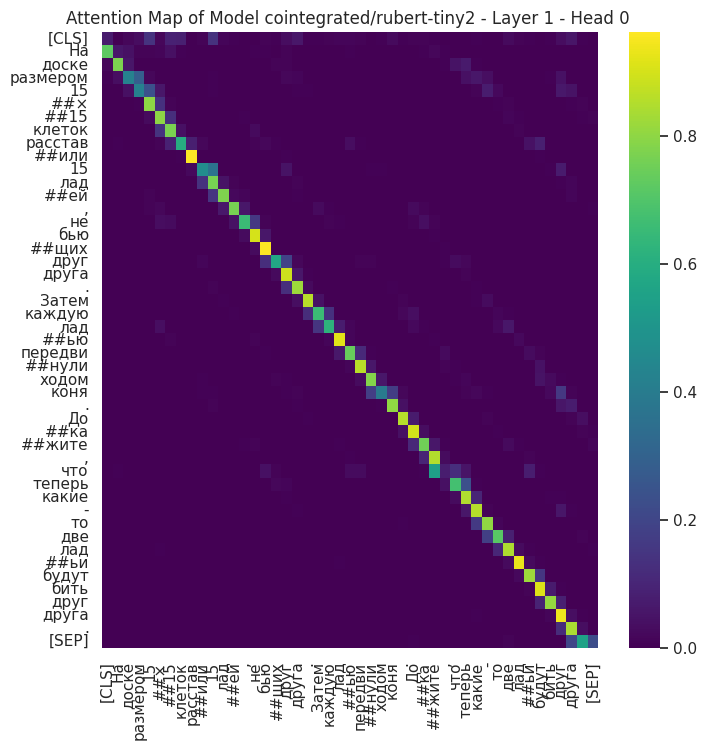

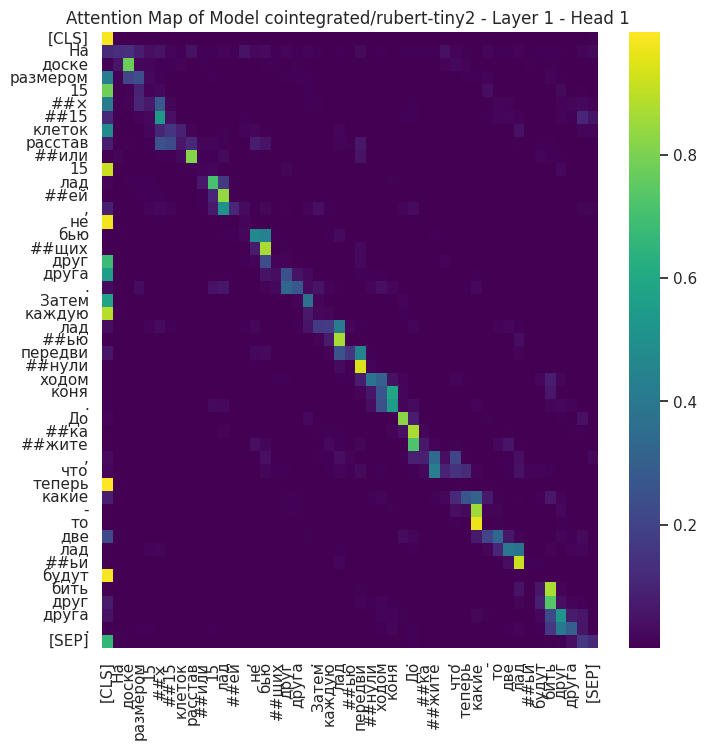

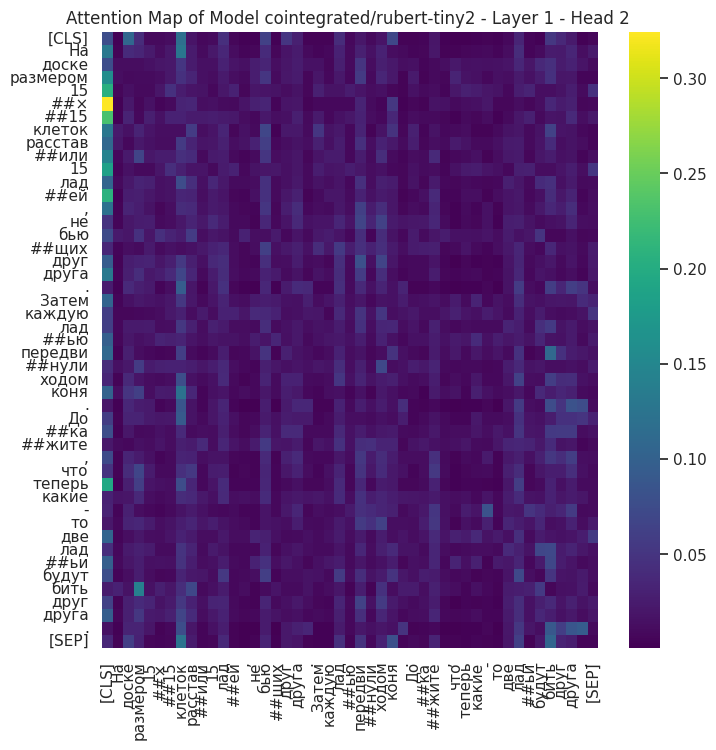

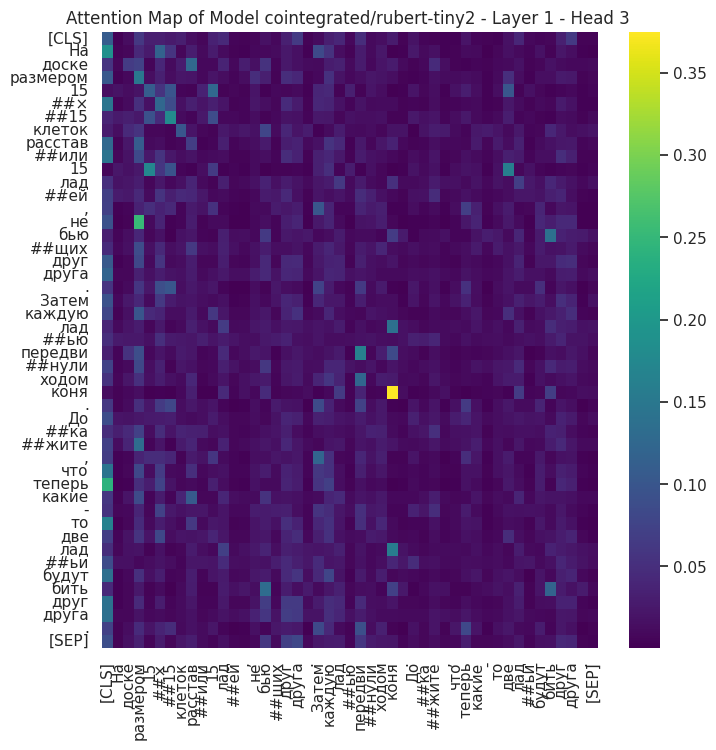

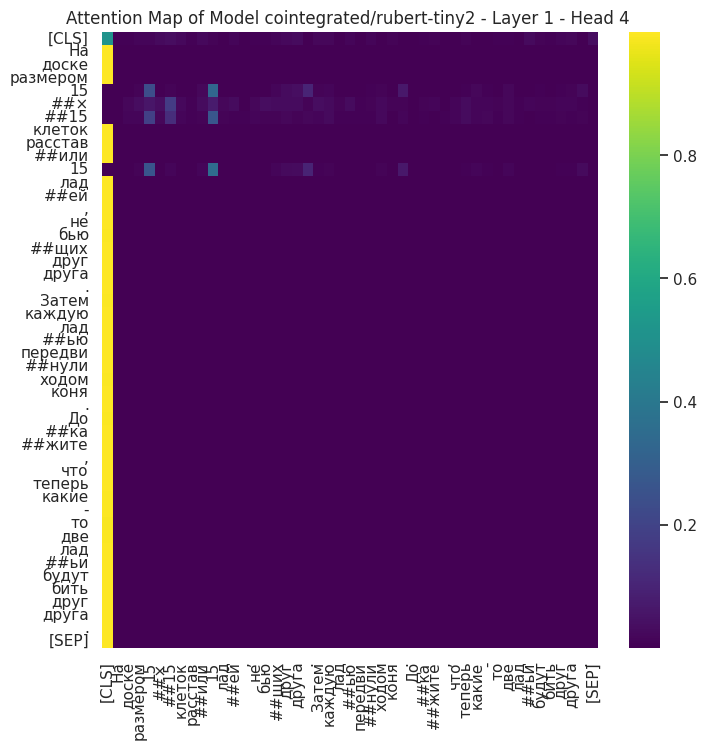

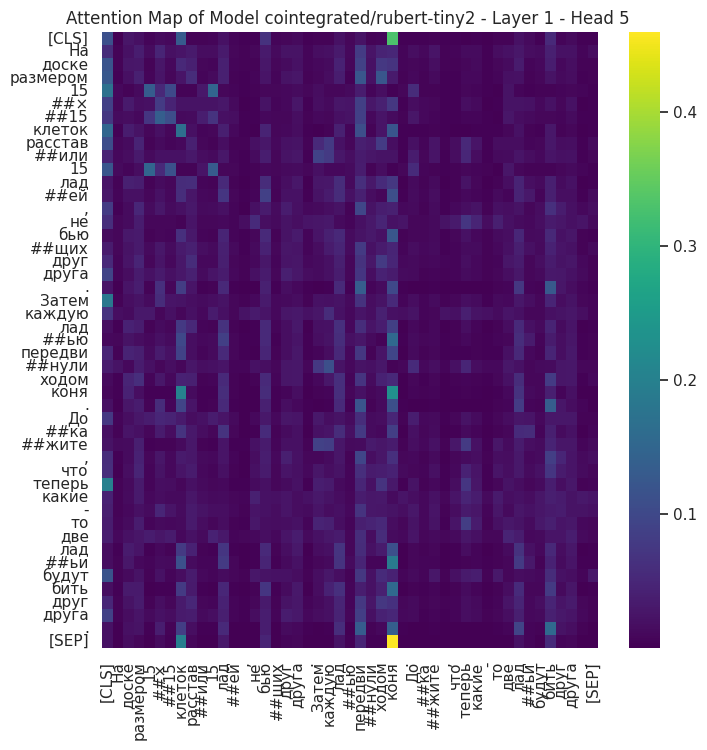

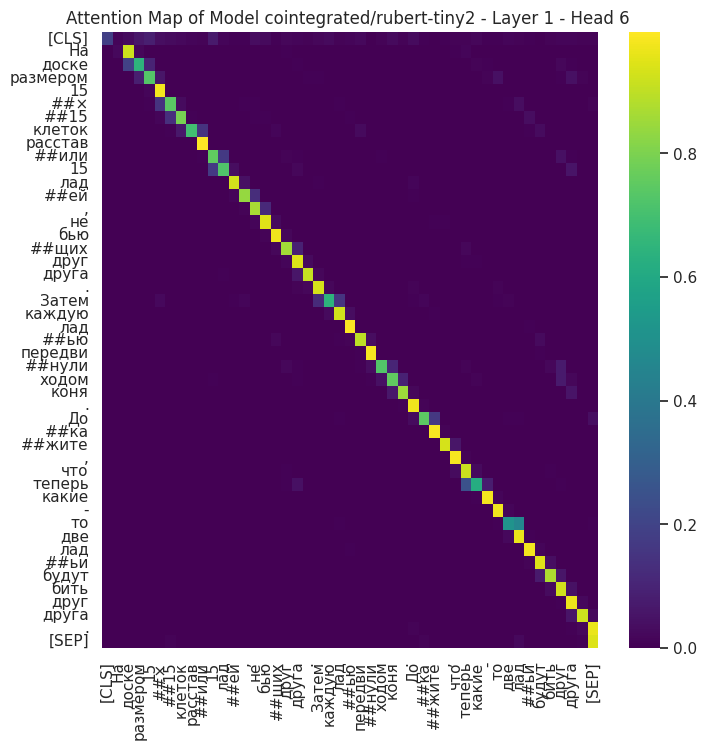

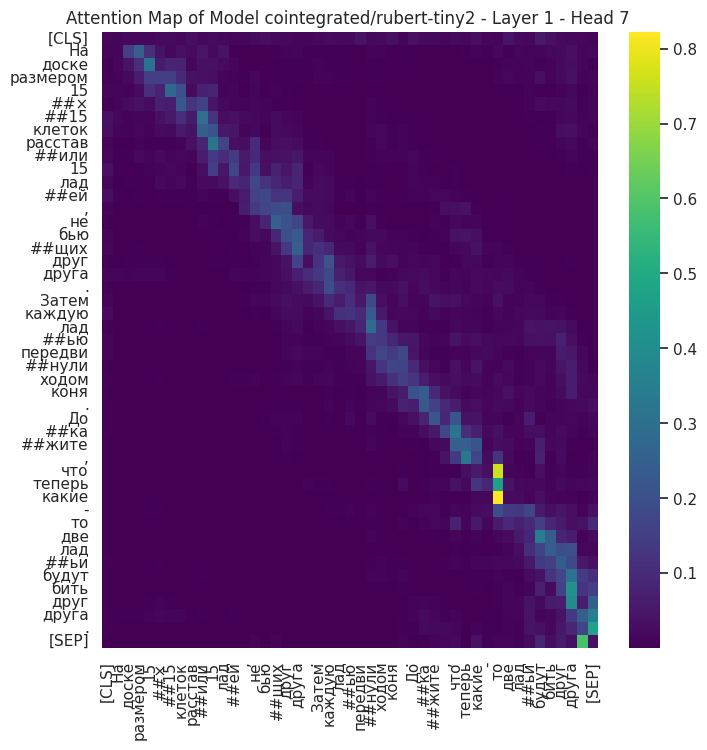

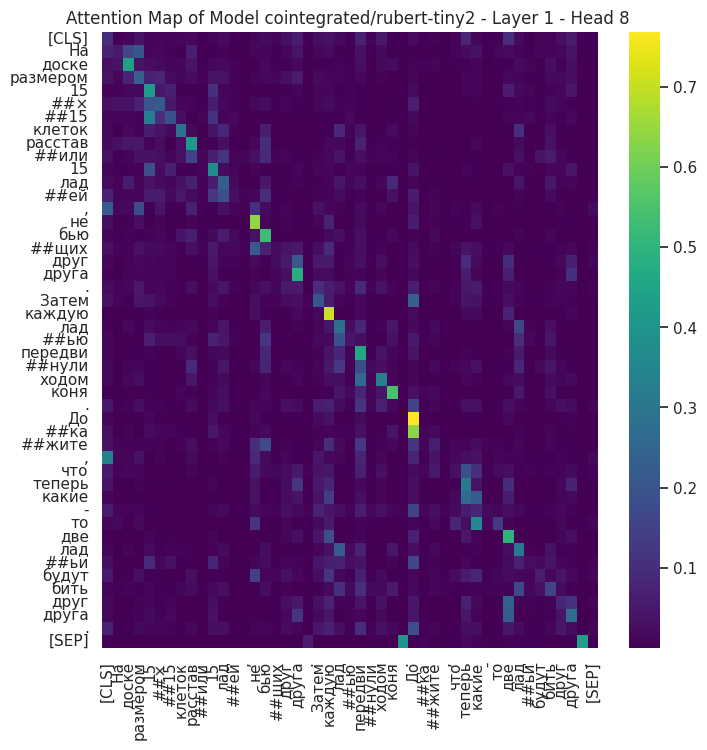

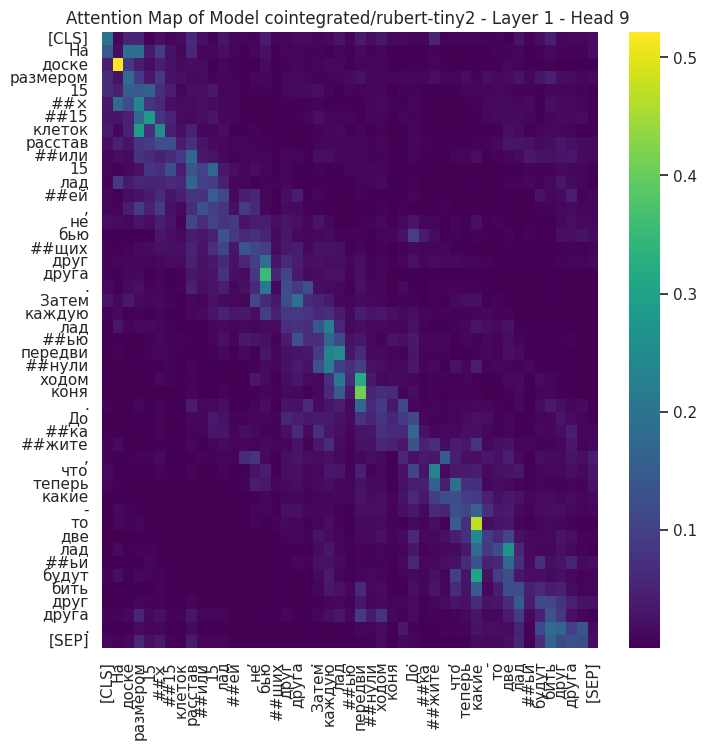

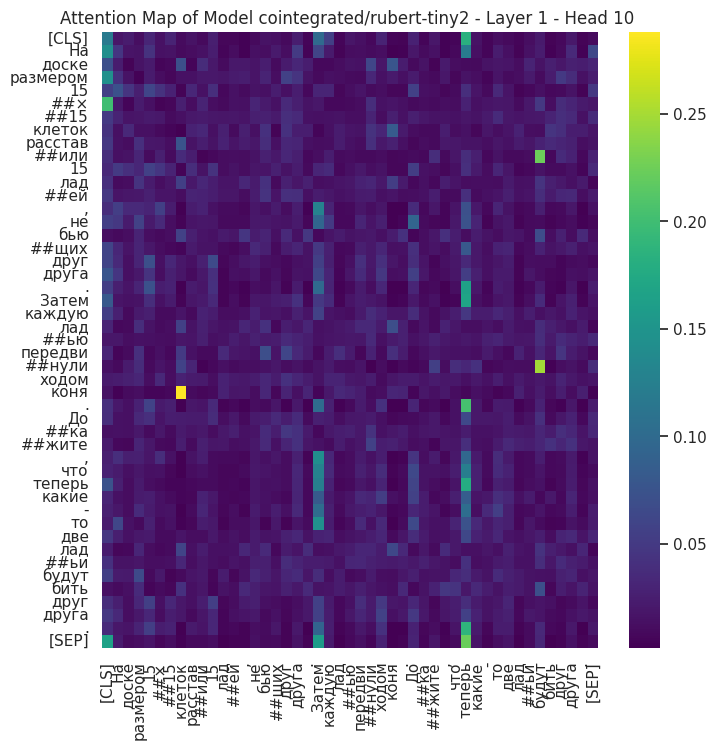

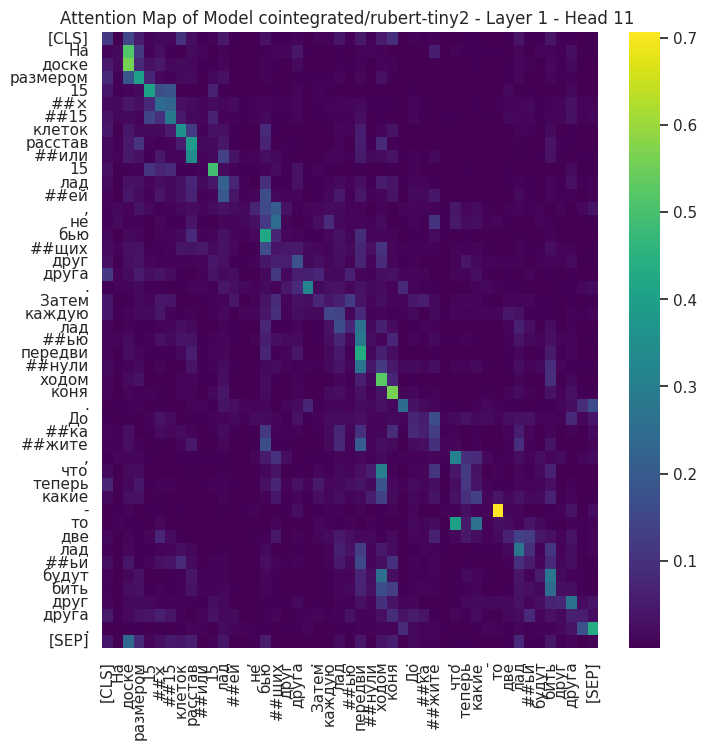

In [ ]:
draw_first_layer_attention_maps(model_RT, RT_checkpoint, math_problem)

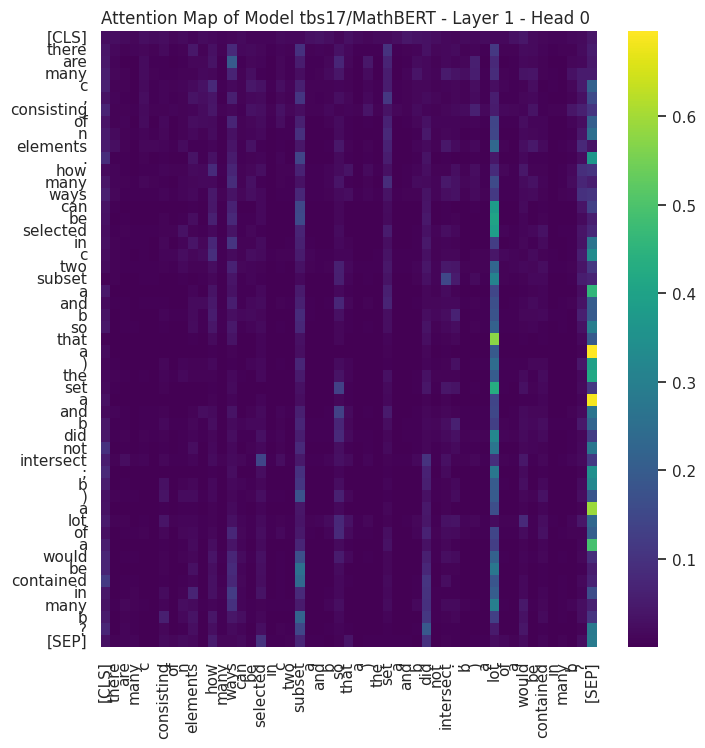

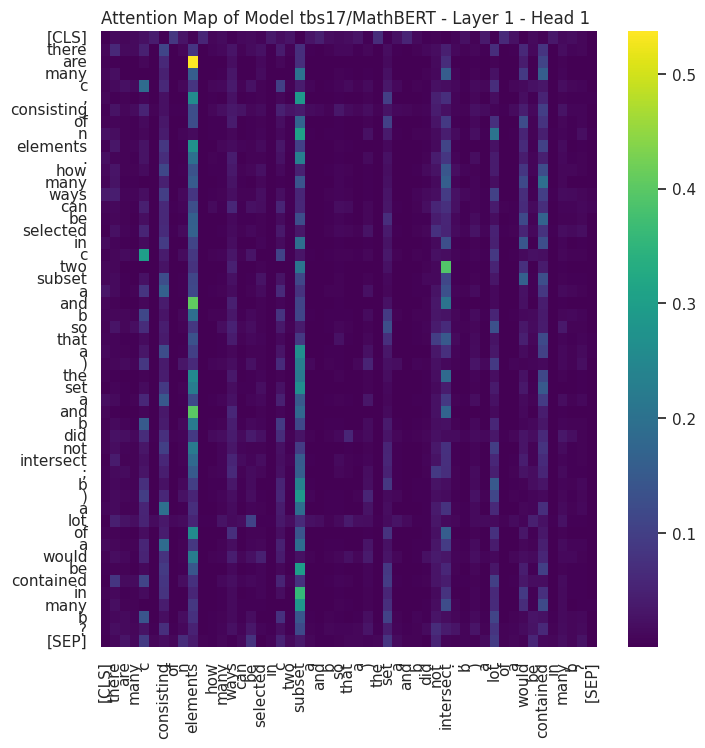

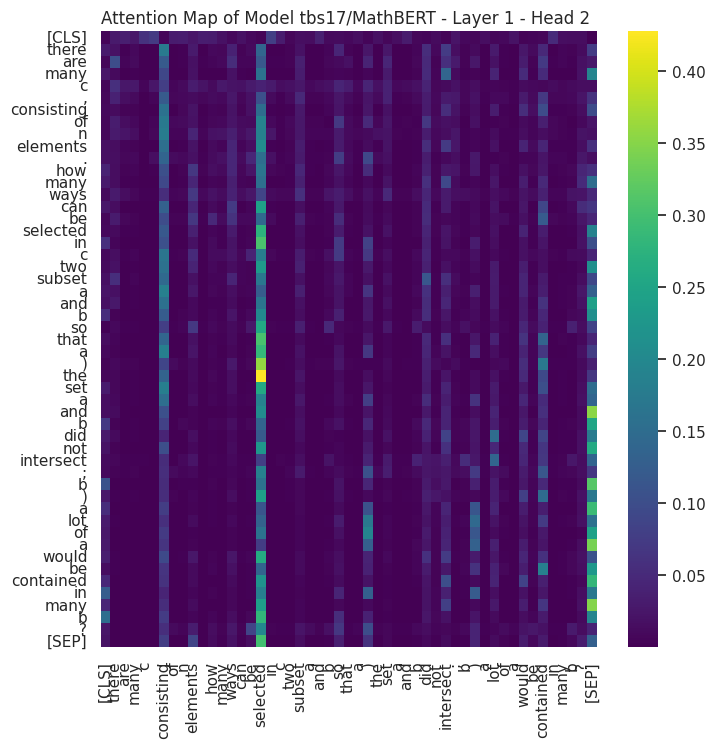

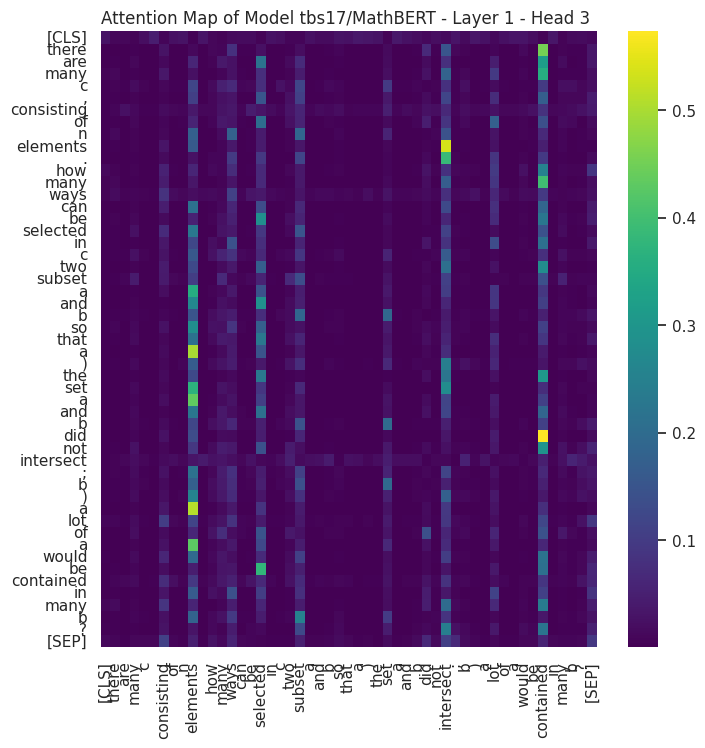

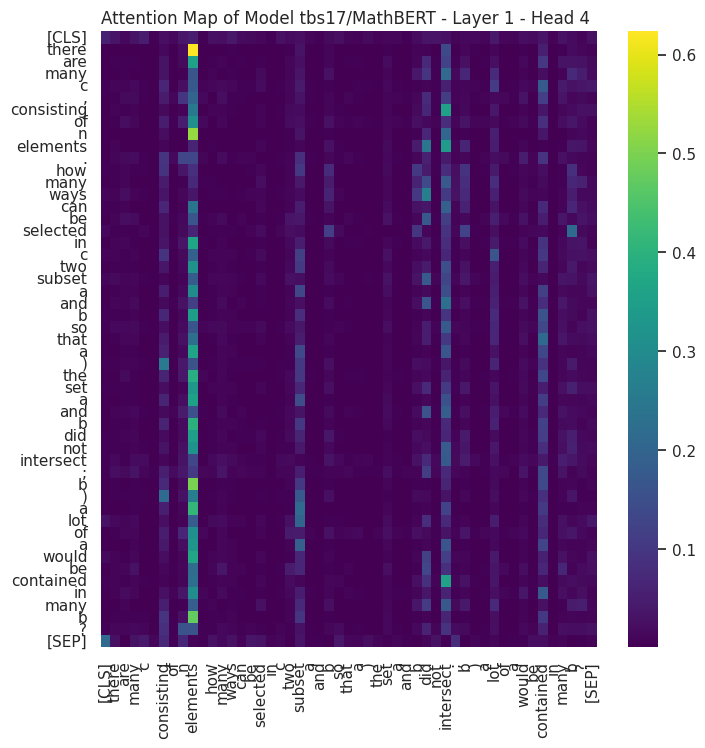

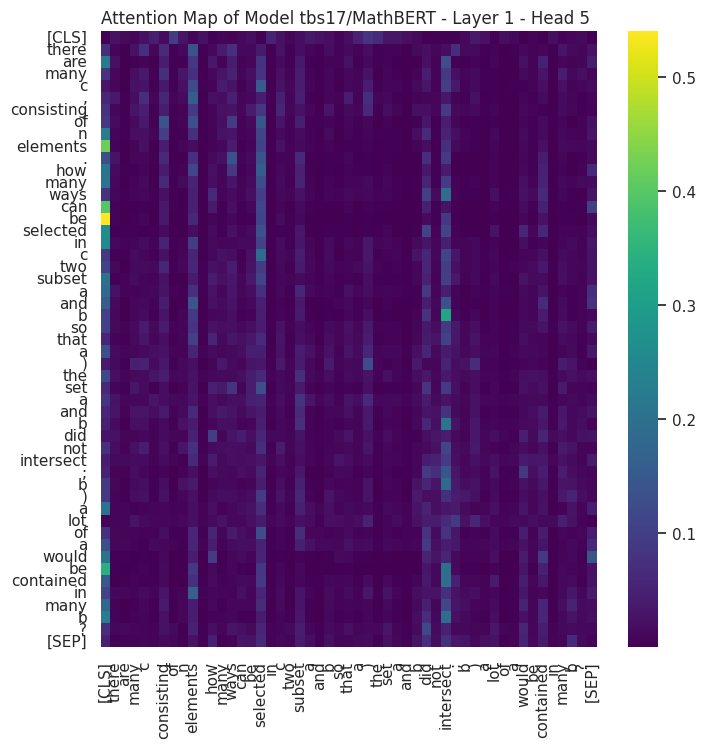

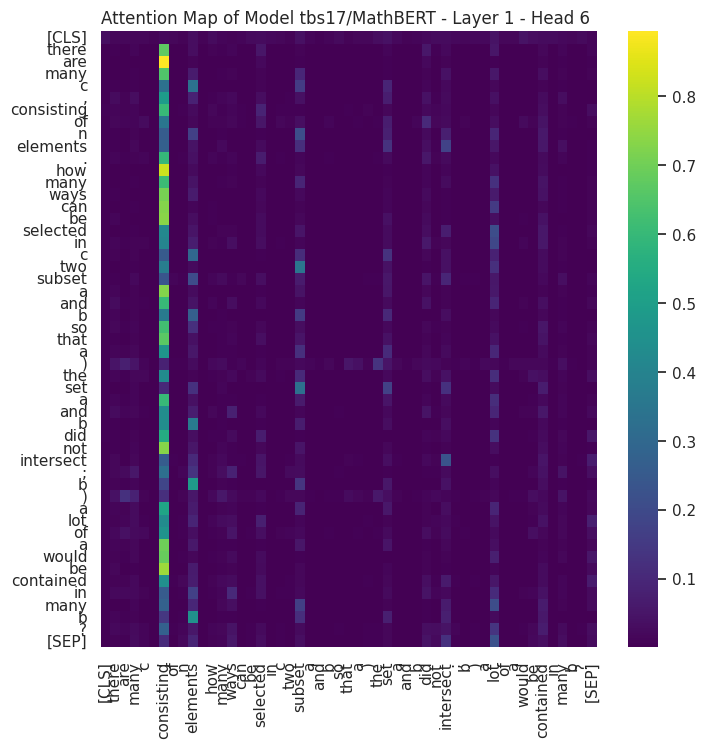

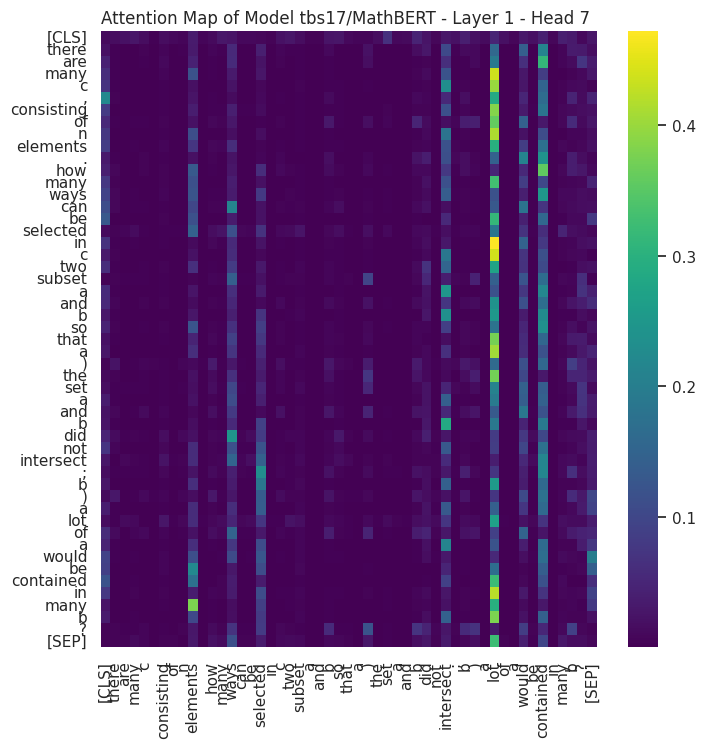

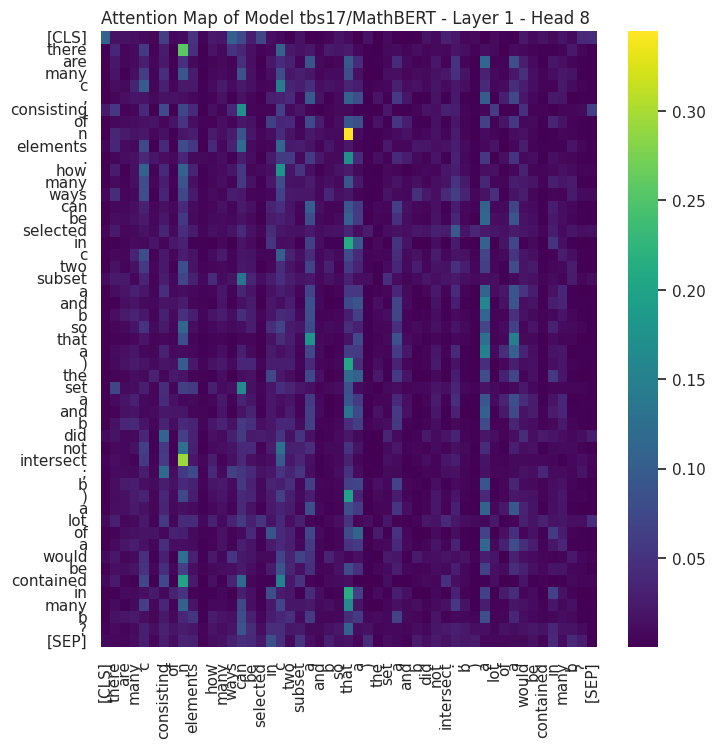

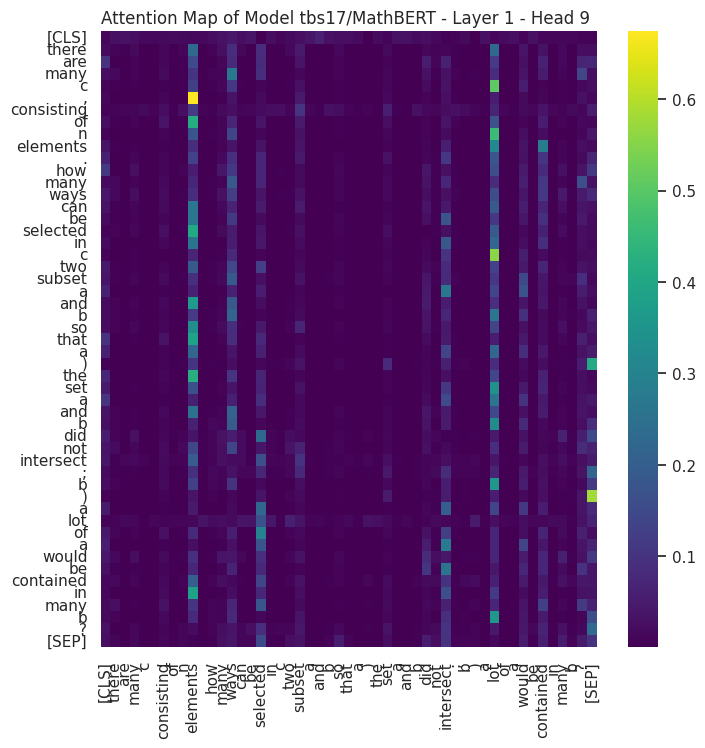

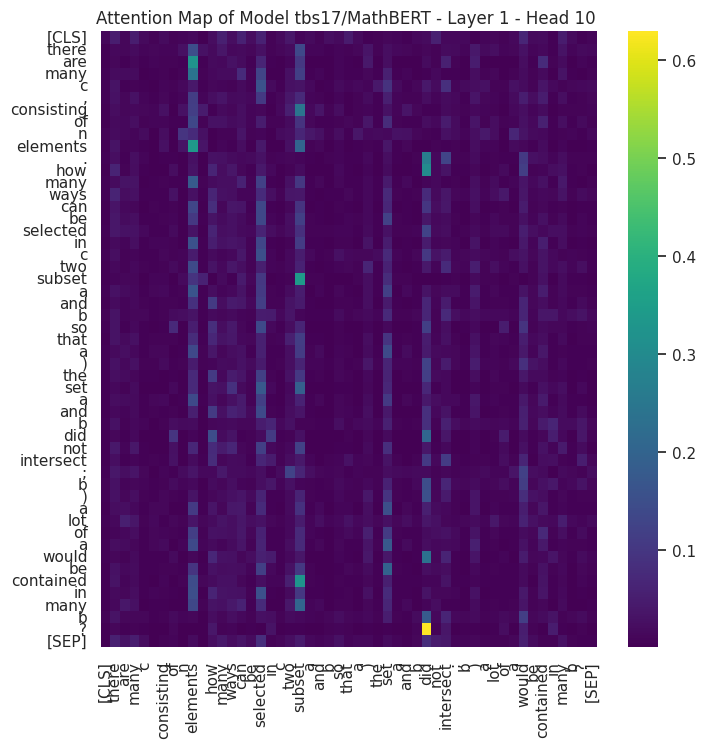

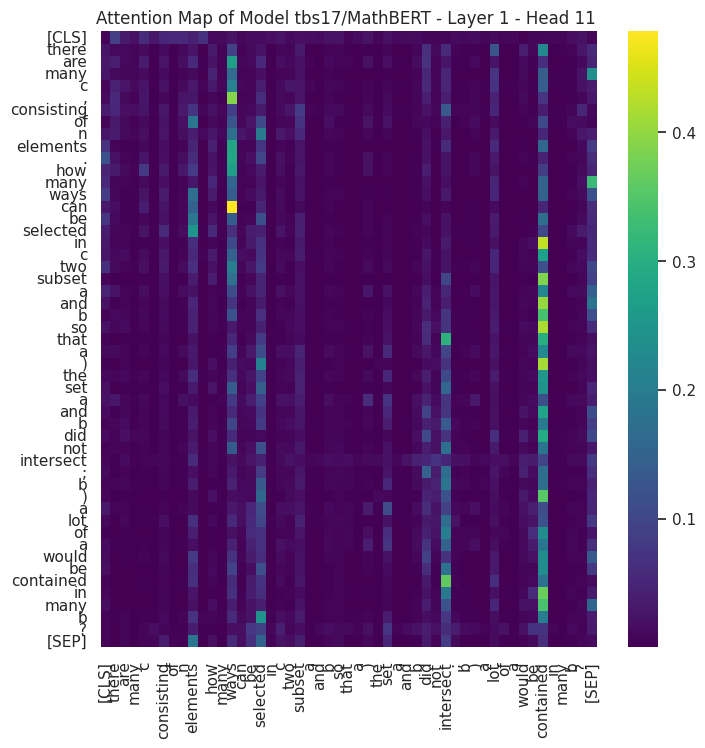

In [ ]:
draw_first_layer_attention_maps(model_MATHBERT, MATHBERT_checkpoint, math_problem_en)

In my exploration, I noticed that various heads within the attention mechanism focus on different connections between tokens. This suggests that each head specializes in capturing specific relationships or patterns within the input data.



**Conclusion/Summary**:

I fine-tuned two models for my task:

The cointegrated/rubert-tiny2 model was fine-tuned using the raw dataset.

The MathBERT model, on the other hand, was originally trained on an English corpus. Therefore, to utilize it effectively, a translated dataset is required. However, I haven't achieved satisfactory results with this model yet.

Although the task was originally defined as multiclass classification, the dataset provided contained a small subset of duplicates with different labels (topics). So I filtered out these duplicate samples.

